In [102]:
# sys = 'dpdo280k'
# trj = "/data/gulab/yzdai/dyz_project1/data/dppc_dopc_280k/traj-dpdo280k-0-10us-pbc.xtc"
# pdb = "/data/gulab/yzdai/dyz_project1/data/dppc_dopc_280k/dppc_dopc_280k_0us.gro"
# fn_leaflet = '/data/gulab/yzdai/data4/phase_identification/leaflet/dpdo280k-leaflet.xvg'
# start = 9000
# end = 10000
# primary_lipid_id = list(range(1, 347)) + list(range(577, 923))
# primary_lipid_id = [str(x) for x in primary_lipid_id]

########################################################################


# sys='dpdochl280k'
# pdb="/data/gulab/yzdai/dyz_project1/data/dppc_dopc_chl_280k/snapshot9.99us.gro"
# trj="/data/gulab/yzdai/dyz_project1/data/dppc_dopc_chl_280k/dpdochl280k-8us-pbc.xtc"
# fn_leaflet='/data/gulab/yzdai/data4/phase_identification/leaflet/dpdochl280k-leaflet.xvg'
# start = 7000
# end = 8000

sys='dpdochl290k'
pdb="/data/gulab/yzdai/dyz_project1/data/dppc_dopc_chl_290k/dppc_dopc_chol_aa_290k_0us.gro"
trj="/data/gulab/yzdai/dyz_project1/data/dppc_dopc_chl_290k/dpdochl290k-0-9.45us-pbc.xtc"
fn_leaflet='/data/gulab/yzdai/data4/phase_identification/leaflet/dpdochl290k-leaflet.xvg'
start = 8000
end = 9000

primary_lipid_id = list(range(1, 203)) + list(range(577, 779))
primary_lipid_id = [str(x) for x in primary_lipid_id]

########################################################################

# sys='psmdopochl'
# pdb="/data/gulab/yzdai/dyz_project1/data/psmdopochl/psmdopochl-rho0.8.gro"
# trj="/data/gulab/yzdai/dyz_project1/data/psmdopochl/trjcat-psmdopochl-rho0.8-1ns-1-22.xtc"
# fn_leaflet='/data/gulab/yzdai/data4/phase_identification/leaflet/psmdopochl300k-0.8-0-20us-leaflet.xvg'
# start = 19000
# end = 20000
# primary_lipid_id = list(range(1, 91)) + list(range(91, 181))
# primary_lipid_id = [str(x) for x in primary_lipid_id]

cal_ratio = False
n_gap = 5
bin_width = 3
outpath = '/data/gulab/yzdai/data4/phase_identification/phase_out/' + sys + '/' + str(start) + '-' + str(end) + '/'
param = "None"
# gmm_param = '/data/gulab/yzdai/data4/phase_identification/phase_out/' + sys + '/' + 'gmm_parameters.json'

In [2]:
import matplotlib
from joblib import Parallel, delayed
import MDAnalysis
import seaborn as sns
import json
import os
from scipy.stats import norm
import argparse
from sklearn.cluster import KMeans
from matplotlib.ticker import LinearLocator
from scipy.ndimage import gaussian_filter
from scipy.ndimage import uniform_filter
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from copy import deepcopy
from collections import Counter
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [3]:
def plot_density_distr(data, title = 'Distribution of Density'):
	# 确保数据是 NumPy 数组
	if isinstance(data, list):
		data = np.array(data)  
	# 如果是二维数组，提取第一个维度
	if data.ndim == 2:
		data = data[:, 0]
	# 检查数据是否为空
	if len(data) == 0:
		print("Error: The input data is empty.")
		return
	# 方法1：使用 seaborn 的 distplot (基础分布图)
	plt.figure(figsize=(4, 3))
	print('start of plotting')
	sns.kdeplot(data, fill=False)
	plt.title(title)
	plt.tick_params(direction='in')
	plt.xlabel('Density')
	plt.ylabel('Probability density')
	# plt.savefig(outpath+sys+'-'+str(start)+'-density.png', dpi=350)
	# plt.close()  # 关闭图形，避免占用内存
def plot_3density_distr(data1, data2, data3, lable0='ALL',title='Distribution of Density Values'):
	plt.figure(figsize=(4, 3))
	# 计算直方图数据，增加bins的数量使基础数据更细致
	bins = np.linspace(min(np.min(data1), np.min(data2), np.min(data3)), 
					  max(np.max(data1), np.max(data2), np.max(data3)), 
					  50)  # 增加bins数量
	hist1_raw, _ = np.histogram(data1, bins=bins)
	hist2, _ = np.histogram(data2, bins=bins)
	hist3, _ = np.histogram(data3, bins=bins)

	# 转换为频率
	hist1 = hist1_raw / np.sum(hist1_raw)  # 归一化处理
	hist2 = hist2 / np.sum(hist1_raw)
	hist3 = hist3 / np.sum(hist1_raw)

	# 使用高斯滤波平滑直方图数据
	hist1_smooth = gaussian_filter(hist1, sigma=2)  # sigma控制平滑程度
	hist2_smooth = gaussian_filter(hist2, sigma=2)
	hist3_smooth = gaussian_filter(hist3, sigma=2)
	# 计算bin中心点
	bin_centers = (bins[:-1] + bins[1:]) / 2
	# 绘制平滑后的曲线
	plt.plot(bin_centers, hist1_smooth, color='black', label=lable0, linewidth=2)
	plt.plot(bin_centers, hist2_smooth, color='red', label=r"L$_{\mathit{d}}$", linewidth=2)
	plt.plot(bin_centers, hist3_smooth, color='blue', label=r"L$_{\mathit{o}}$", linewidth=2)

	plt.title(title)
	plt.tick_params(direction='in')
	plt.xlabel('Normed density')
	plt.ylabel('probability')
	plt.legend(fontsize=7, frameon=True)
	# plt.savefig(outpath+sys+'-'+str(start)+'-phase-density.png', dpi=350)
def remove_isolated_points_and_smooth(labels, iter):
	rows, cols = labels.shape
	for _ in range(iter):
		new_labels = np.copy(labels)
		for i in range(rows):
			for j in range(cols):
				# 获取周围 5x5 的邻居，考虑周期性边界条件
				neighbors = []
				for di in range(-2, 3):  # 行偏移范围 [-2, 2]
					for dj in range(-2, 3):  # 列偏移范围 [-2, 2]
						if di == 0 and dj == 0:  # 排除中心元素本身
							continue
						neighbor_value = labels[(i + di) % rows, (j + dj) % cols]
						neighbors.append(neighbor_value)
				# 统计出现次数的字典，忽略 NaN
				counts = {}
				for value in neighbors:
					if not np.isnan(value):  # 忽略 NaN
						counts[value] = counts.get(value, 0) + 1
				# 找到出现最多次的值
				max_count = -1
				most_frequent = None
				for key, count in counts.items():
					if count > max_count:
						max_count = count
						most_frequent = key
				# 替换 NaN
				new_labels[i, j] = most_frequent
		labels = np.copy(new_labels)
	return new_labels
def plot_phase(edge_list, cluster_matrix):
	 # Make figure with regular contour plot 
	levels = LinearLocator(numticks=16).tick_values(0, 1)      #这里需要改
	cmap = plt.get_cmap('RdYlBu')
	xMatrix = np.zeros((cluster_matrix.shape[0], cluster_matrix.shape[1]))
	yMatrix = np.zeros((cluster_matrix.shape[0], cluster_matrix.shape[1]))
	xaxis = edge_list[0][1:]
	yaxis = edge_list[1][1:]
	for i in range(0, cluster_matrix.shape[0]):
		xMatrix[i, :] = xaxis
	for j in range(0, cluster_matrix.shape[1]):
		yMatrix[:, j] = yaxis

	im = plt.contourf(yMatrix,
			 xMatrix, cluster_matrix, levels=levels,
			 cmap=cmap)
	densmap = plt.gca()
	densmap.set_aspect(1)
	#set border width
	densmap.spines['bottom'].set_linewidth(2)
	densmap.spines['left'].set_linewidth(2)
	densmap.spines['top'].set_linewidth(2)
	densmap.spines['right'].set_linewidth(2)
	densmap.tick_params(axis='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
	return im
def get_lip_grid_ndx(atoms_grid_indexs, atoms_lipid, leaflet):
	# atoms_grid_indexs: natoms*5*2
	# atoms_lipid: natoms*1
	####第一步：获得每个原子在5ns中最多次定位在哪个grid,作为该原子的唯一grid index
	atoms_most_grid_index = []
	# 遍历每个原子
	for atom_grid_indexs in atoms_grid_indexs:
		# 统计当前原子的grid indexs元组出现的次数
		counter = Counter(atom_grid_indexs)
		# 得到出现次数最多的grid index元组
		most_grid_index = counter.most_common(1)[0][0]
		# 将结果加入列表
		atoms_most_grid_index.append(most_grid_index)
	# 此时atoms_most_grid_index: natoms*2....[(0,1),(0,1),...,(4,5)]
	####第二步：对于每个lipid，根据其原子，确定lipid所属的grid indexs列表
	# 创建一个字典，存放每个resid的grid indexs列表及计数
	# 类似：
	# {
	#     lipid_id_1: Counter({grid_index_1: count_1, grid_index_2: count_2, ...}),
	#     lipid_id_2: Counter({grid_index_3: count_3, grid_index_4: count_4, ...}),
	#     ...
	# }
	lip_grid_indexs = {}
	for grid_index, lipid_id in zip(atoms_most_grid_index, atoms_lipid):
		# 如果分子 ID 不在字典中，则将其添加到字典，并初始化为一个空的 Counter
		if lipid_id not in lip_grid_indexs:
			lip_grid_indexs[lipid_id] = Counter()
		# 将当前原子的标签添加到对应分子的 Counter 中
		lip_grid_indexs[lipid_id][grid_index] += 1
	for key in lip_grid_indexs.keys():
		lip_grid_counter = lip_grid_indexs[key]
		lip_grid_indexs[key] = [lip_grid_counter, leaflet]
	return lip_grid_indexs 
def get_atom_grid_position(atom_coords, x_grid_points, y_grid_points):
	x_grid_points[0] = 0
	y_grid_points[0] = 0
	grids_index = []
	for atom in atom_coords[:,:2]:
		x_coord, y_coord = atom
		# 查找在x轴和y轴上的索引
		x_index = np.searchsorted(x_grid_points, x_coord, side='left') - 1
		y_index = np.searchsorted(y_grid_points, y_coord, side='left') - 1
		grids_index.append([(x_index, y_index)]) 
		# grids_index.append([(y_index, x_index)])
	return grids_index
def simulate_PBC(points_leaflet, box, r=0.3, edge=None):
	PBC_points = []
	# 使用 edge 来限制输出范围
	if edge is not None:
		x_min, x_max = edge[0][0], edge[0][-1]
		y_min, y_max = edge[1][0], edge[1][-1]
	else:
		x_min = 0
		x_max = (1 + r) * box[0]
		y_min = 0
		y_max = (1 + r) * box[1]
	for x, y, z in points_leaflet:
		# 原始点
		if x_min < x < x_max and y_min < y < y_max:
			PBC_points.append([x, y, z])
		# 方向平移（仅 x/y）
		shifts = []
		if x > (1 - r) * box[0]: shifts.append([-box[0], 0])
		if x < r * box[0]:        shifts.append([ box[0], 0])
		if y > (1 - r) * box[1]: shifts.append([0, -box[1]])
		if y < r * box[1]:        shifts.append([0,  box[1]])
		# 斜角方向组合（左上、右上、左下、右下）
		if x > (1 - r) * box[0] and y < r * box[1]:
			shifts.append([-box[0], box[1]])
		if x > (1 - r) * box[0] and y > (1 - r) * box[1]:
			shifts.append([-box[0], -box[1]])
		if x < r * box[0] and y < r * box[1]:
			shifts.append([ box[0], box[1]])
		if x < r * box[0] and y > (1 - r) * box[1]:
			shifts.append([ box[0], -box[1]])
		# 平移后坐标加入
		for dx, dy in shifts:
			new_x, new_y = x + dx, y + dy
			if x_min < new_x < x_max and y_min < new_y < y_max:
				PBC_points.append([new_x, new_y, z])
	return np.array(PBC_points)
def cal_density(u, sel, sel_key, diffnp, edge, box_fr):
	# Get the coordinates of the selected atoms
	sel_atoms_obj = u.select_atoms(sel)
	sel_atoms = sel_atoms_obj.positions
	# Move the com of system to the center of present box
	sel_atoms_com = np.add(sel_atoms, diffnp)
	# Rescale the coordinates between 0 - present boxsize
	sel_atoms_pbc = np.mod(sel_atoms_com, box_fr)
	# Generate some fake points to simulate PBC to fill the max box
	PBC_points = simulate_PBC(sel_atoms_pbc, box_fr, r=0.3, edge = edge) 
	# Get the number of atoms within each grid
	# h, _ = np.histogramdd(sel_atoms_pbc, bins=edge, normed = False)
	h, _ = np.histogramdd(PBC_points, bins=edge, normed = False)

	assert np.all(h >= 0), "Histogram contains negative counts!"
	# Convert histogram to densities 
	# x_edges, y_edges, z_edges = edge
	# dx = np.diff(x_edges) 
	# dy = np.diff(y_edges) 
	# dz = np.diff(z_edges) 
	# dx_mesh, dy_mesh, dz_mesh = np.meshgrid(dx, dy, dz, indexing='ij')
	# volumes = dx_mesh * dy_mesh * dz_mesh 
	# dens3d = h / volumes

	volume = bin_width*bin_width*bin_width/6
	dens3d = h / volume

	# Collapse along the z-axis
	# top 1/2 mean
	xy = dens3d.shape[0] * dens3d.shape[1]
	z = dens3d.shape[2]
	reshaped = dens3d.reshape(xy, z)
	mean_vals = np.zeros(xy)
	for i in range(xy):
		row = reshaped[i]
		nonzero = row[row > 0]
		if len(nonzero) > 0:
			sorted_vals = np.sort(nonzero)
			num_keep = max(1, len(sorted_vals) // 2)
			mean_vals[i] = np.mean(sorted_vals[-num_keep:])
	dens2d_mean = mean_vals.reshape(dens3d.shape[0], dens3d.shape[1])
	# # 策略： top 1/2 mean
	# dens2d_mean = np.zeros(shape = (dens3d.shape[0], dens3d.shape[1]))

	# for i in range(0, dens3d.shape[0]):
	#     for j in range(0, dens3d.shape[1]):
	#         all_z = dens3d[i, j, :]
	#         nonzero = all_z[all_z>0]
	#         if len(nonzero) > 0:
	#             sorted_z = sorted(nonzero, reverse=True)
	#             top_n = max(1, len(sorted_z) // 2)
	#             top_z = sorted_z[:top_n]
	#             dens2d_mean[i,j] = np.array(top_z).mean()
	# sum
	dens2d_sum = dens3d.sum(axis=2)

	# Get the grid index and resid for each atom.
	if(sel_key == 'atom_upper'):
		sel_atoms2grids_index_up = get_atom_grid_position(sel_atoms_pbc, edge[0][:], edge[1][:])
		sel_atoms2lips_up =  sel_atoms_obj.resids
		return dens2d_sum, dens2d_mean, sel_atoms2grids_index_up, sel_atoms2lips_up
	elif(sel_key == 'atom_lower'):
		sel_atoms2grids_index_low = get_atom_grid_position(sel_atoms_pbc, edge[0][:], edge[1][:])
		sel_atoms2lips_low = sel_atoms_obj.resids
		return dens2d_sum, dens2d_mean, sel_atoms2grids_index_low, sel_atoms2lips_low
	else:
		return dens2d_sum, dens2d_mean
def get_lipis_tags(tags_up_all, tags_low_all, lips_grid_ndx):
	lips_tag = []
	for t in range(len(lips_grid_ndx)): #200
		lips_tag_fr = []
		for lip_index in range(len(lips_grid_ndx[0])):  #对于每个lip的n个grid index
			lip_grids_counter, leaflet = lips_grid_ndx[t][lip_index]
			lip_tag_counts = Counter()
			for grid_index, count in lip_grids_counter.items():
				(i, j) = grid_index
				if (leaflet == 0): #gird index 转为tag
					tag = int(tags_up_all[t][i][j])
				else:
					tag = int(tags_low_all[t][i][j])
				lip_tag_counts[tag] += count
			most_common_tag, _ = lip_tag_counts.most_common(1)[0]
			lips_tag_fr.append(most_common_tag)
		lips_tag.append(lips_tag_fr)
	return lips_tag
def spatial_smooth(matrix, n_iter=2, n_size =3):
	new_matrix = deepcopy(matrix)
	for i in range(n_iter):
		new_matrix = np.around(uniform_filter(new_matrix, size = n_size, mode='wrap'), decimals=6)
	return new_matrix
def get_tag_by_first_feature(data,raw_tags):
	# 计算每个聚类中第一个特征的均值
	means = []
	for cluster in set(raw_tags):
		cluster_points = data[raw_tags == cluster]  # 提取当前标签对应的样本
		mean_value = cluster_points[:, 0].mean()  # 计算第一个特征的均值
		means.append((cluster, mean_value))
	# 根据均值大小重新定义标签
	means.sort(key=lambda x: x[1])  # 按均值排序，较小均值排在前面
	mapping = {means[0][0]: 0, means[1][0]: 1}  # 均值小的映射为 2，均值大的映射为 1
	# 映射原始标签到新的标签
	new_tags = np.array([mapping[tag] for tag in raw_tags])
	return new_tags
def combine_tags(tags_2, new_tags_of1):
	# 创建一个与原始标签相同长度的数组
	final_tags = np.copy(tags_2)
	# 找到原始标签中为1的索引
	indices_of_1 = np.where(tags_2 == 1)[0]
	# 将二次分类的结果放回原来的位置
	# 如果二次分类为1的部分要标记为2，可以将new_tags_of1加1
	final_tags[indices_of_1] = new_tags_of1
	return final_tags
def cluster_all(atom_dens_mean_up_all_raw, atom_dens_mean_low_all_raw,
				k=2, iterations=1, gmm_param=None):
	if gmm_param != 'None':
		# Step 1: 读取 JSON 文件
		with open(gmm_param, 'r') as json_file:
			params = json.load(json_file)
		# 提取 Ld 和 Lo 的参数
		density_mean = params['density']['mean']
	else:
		density_mean = np.mean(atom_dens_mean_up_all_raw)/2+np.mean(atom_dens_mean_low_all_raw)/2
	# 数据处理，空间上均值滤波
	density_up_filtered_all = []
	density_low_filtered_all = []
	for n_fr in range(atom_dens_mean_up_all_raw.shape[0]):
		density_mean_up_fr = atom_dens_mean_up_all_raw[n_fr]
		density_mean_low_fr = atom_dens_mean_low_all_raw[n_fr]
		if np.any(density_mean_up_fr == 0):
			density_mean_up_fr = replace_zeros_with_neighbors_mean(density_mean_up_fr)
		if np.any(density_mean_low_fr == 0):
			density_mean_low_fr = replace_zeros_with_neighbors_mean(density_mean_low_fr)
		# 对原始数值进行空间上均值滤波
		density_up_normed_fr = density_mean_up_fr/density_mean
		density_low_normed_fr = density_mean_low_fr/density_mean
		density_up_filtered_fr = spatial_smooth(density_up_normed_fr)
		density_low_filtered_fr = spatial_smooth(density_low_normed_fr)

		density_up_filtered_all.append(density_up_filtered_fr)
		density_low_filtered_all.append(density_low_filtered_fr)
	density_up_filtered_all = np.array(density_up_filtered_all)
	density_low_filtered_all = np.array(density_low_filtered_all)
	# 将数组转换为2D形式，以便进行KMeans聚类
	n_leaflet_samples = atom_dens_mean_up_all_raw.shape[0]*atom_dens_mean_up_all_raw.shape[1]*atom_dens_mean_up_all_raw.shape[2]
	density_up_flattened = density_up_filtered_all.reshape(n_leaflet_samples, -1).tolist()
	density_low_flattened = density_low_filtered_all.reshape(n_leaflet_samples, -1).tolist()
	density_flattened = density_up_flattened + density_low_flattened
	# [atom]
	flattened_matrix = density_flattened
	# 去除NA
	flattened_matrix = np.where(np.isnan(flattened_matrix), 0, flattened_matrix)
	# 检查 NaN
	has_nan = np.isnan(flattened_matrix).any()
	if has_nan:
		print("Array contains NaN values.")
	# 检查 Infinity
	has_inf = np.isinf(flattened_matrix).any()
	if has_inf:
		print("Array contains infinite values.")
	###画分布图###
	plot_density_distr(flattened_matrix, title=sys+' '+str(start)+'-'+str(end))
	# 开始分类
	if (gmm_param != 'None'):
		n_fr  = density_up_filtered_all.shape[0]
		tags_up_all = []; tags_low_all = []
		for fr in range(n_fr):
			filter_fr = threshold_max - (threshold_max - threshold_min) * fr/n_fr
			density_up_filtered_fr = density_up_filtered_all[fr]
			tags_up_fr = (density_up_filtered_fr > filter_fr).astype(int)
			tags_up_all.append(tags_up_fr)
			density_low_filtered_fr = density_low_filtered_all[fr]
			tags_low_fr = (density_low_filtered_fr > filter_fr).astype(int)
			tags_low_all.append(tags_low_fr)
		tags_up_flattened = np.array(tags_up_all).reshape(n_leaflet_samples, -1).tolist()
		tags_low_flattened = np.array(tags_low_all).reshape(n_leaflet_samples, -1).tolist()
		tags = tags_up_flattened + tags_low_flattened
		tags = np.array(tags)

	if (gmm_param == 'None'):
		# Step 1: 高斯混合模型拟合
		gmm = GaussianMixture(n_components=k, random_state=0).fit(flattened_matrix)   
		raw_tags = gmm.predict(flattened_matrix)

		# Step 2: 对 raw_tags 进行处理，得到最终标签 tags
		tags = get_tag_by_first_feature(flattened_matrix,raw_tags)

		# Step 3: 根据 tags 提取 Lo 和 Ld 的分布参数
		ld_indices = (tags == 0)  # Ld 标签为 0
		lo_indices = (tags == 1)  # Lo 标签为 1
		# 提取 Ld 和 Lo 样本
		ld_samples = flattened_matrix[ld_indices]
		lo_samples = flattened_matrix[lo_indices]
		# 计算 Ld 和 Lo 的均值和标准差
		mu_ld, sigma_ld = ld_samples.mean(), ld_samples.std()
		mu_lo, sigma_lo = lo_samples.mean(), lo_samples.std()
		min_lo = min(flattened_matrix[tags == 1])
		max_ld = max(flattened_matrix[tags == 0])
		# Step 4: 保存到 JSON 文件
		output_data = {
			"Ld": {
				"tag": 0,
				"mean": float(mu_ld),
				"std": float(sigma_ld),
				"max density": float(max_ld)
			},
			"Lo": {
				"tag": 1,
				"mean": float(mu_lo),
				"std": float(sigma_lo),
				"min density": float(min_lo)
			},
			"density": {
				"mean": float(density_mean)
			}
		}
		with open(os.path.join(os.path.dirname(os.path.abspath(outpath)), 'gmm_parameters.json'), 'w') as json_file:
			json.dump(output_data, json_file, indent=4)
	# else:
		####方法1：看哪个概率密度大
		# Step 1: 读取 JSON 文件
		# with open(gmm_param, 'r') as json_file:
		#     params = json.load(json_file)
		# # 提取 Ld 和 Lo 的参数
		# mu_ld = params['Ld']['mean']
		# sigma_ld = params['Ld']['std']
		# mu_lo = params['Lo']['mean']
		# sigma_lo = params['Lo']['std']
		# mu_ubld = params['unbalanced_Ld']['mean']
		# sigma_ubld = params['unbalanced_Ld']['std']
		# # Step 2: 计算每个样本的概率密度
		# prob_ld_1 = norm.pdf(flattened_matrix, loc=mu_ld, scale=sigma_ld)  # 属于 Ld 的概率密度
		# prob_ld_2 = norm.pdf(flattened_matrix, loc=mu_ubld, scale=sigma_ubld)  # 属于 Ld 的概率密度
		# prob_ld = np.maximum(prob_ld_1, prob_ld_2)
		# prob_lo = norm.pdf(flattened_matrix, loc=mu_lo, scale=sigma_lo)  # 属于 Lo 的概率密度
		# # Step 3: 分类规则
		# tags = np.where(prob_lo > prob_ld, 1, 
		#         np.where(prob_lo < prob_ld, 0, np.nan))
		
		# ####方法2：单侧检验
		# mu_lo = params['Lo']['mean']
		# sigma_lo = params['Lo']['std']
		# z_score = norm.ppf(0.80)  # 单侧 90% 显著性水平对应的 Z 值（可根据需求调整）
		# # 计算特征值较大的阈值
		# threshold = mu_lo - z_score * sigma_lo  # 比较大的样本特征值阈值
		# print(f"分类阈值 (80% 左单侧显著): {threshold:.3f}")
		# tags = np.where(flattened_matrix > threshold, 1, 0)

		# ####方法3：动态threshold
		# tags = np.where(flattened_matrix > threshold, 1, 0)
		# print('Threshold:\t',threshold)
	print('Lo min:\t',min(flattened_matrix[tags == 1]))
	print('Ld max:\t',flattened_matrix[tags == 0].max())
	plot_3density_distr(flattened_matrix,
					flattened_matrix[tags == 0], 
					flattened_matrix[tags == 1], 
					title=sys+' '+str(start)+'-'+str(end))
	# 将标签数组重新分割为tag_up和tag_low，并还原其形状
	split_idx = len(tags) // 2
	tag_matrixs_up = tags[:split_idx].reshape(atom_dens_mean_up_all_raw.shape[0],atom_dens_mean_up_all_raw.shape[1],atom_dens_mean_up_all_raw.shape[2])
	tag_matrixs_low = tags[split_idx:].reshape(atom_dens_mean_up_all_raw.shape[0],atom_dens_mean_up_all_raw.shape[1],atom_dens_mean_up_all_raw.shape[2])
	# 在像素化平面针对grid的tag进行空间平滑
	final_tag_matrixs_up = deepcopy(tag_matrixs_up)
	final_tag_matrixs_low = deepcopy(tag_matrixs_low)
	for n_fr in range(atom_dens_mean_up_all_raw.shape[0]):
		tag_matrix_up_fr = tag_matrixs_up[n_fr]
		tag_matrix_low_fr = tag_matrixs_low[n_fr]
		final_tag_matrixs_up[n_fr] = remove_isolated_points_and_smooth(tag_matrix_up_fr, iter=iterations) #控制是否平滑
		final_tag_matrixs_low[n_fr] = remove_isolated_points_and_smooth(tag_matrix_low_fr, iter=iterations) #控制是否平滑
	print('end of clustering all')
	return final_tag_matrixs_up, final_tag_matrixs_low
def split_into_segments(sequence):
	segments = []
	current_char = sequence[0]
	count = 1
	
	for char in sequence[1:]:
		if char == current_char:
			count += 1
		else:
			segments.append((current_char, count))
			current_char = char
			count = 1
	segments.append((current_char, count))
	return segments
def merge_segments(segments):
	tmp = list(''.join([char * count for char, count in segments]))
	return tmp
def correct_min_repeat_tags(segments, repeat = 2):
	for r in range(1, repeat+1):
		# print('r = ',r)
		iter = 0
		while True:
			iter += 1
			# print('1st: iter: ' + str(iter))
			if iter > 2000:
				raise RuntimeError("Error: Iteration limit exceeded, potential infinite loop detected!")
			corrected_segments = segments.copy()
			for i in range(len(segments)):
				char, count = segments[i]
				if(len(segments) >= 3):
					if count <= r:
						if i == 0 and len(segments) > 1:
							# 首个segment的处理
							right_char, right_count = segments[i+1]
							if right_count > repeat:
								corrected_segments[i] = (right_char, count)
						elif i == len(segments) - 1 and len(segments) > 1:
							# 末尾segment的处理
							left_char, left_count = segments[i-1]
							if left_count > repeat:
								corrected_segments[i] = (left_char, count)
						else:
							# 中间segment的处理
							left_char, left_count = segments[i-1]
							right_char, right_count = segments[i+1]
							
							if left_count > r or right_count > r:
								if left_count >= right_count:
									corrected_segments[i] = (left_char, count)
								else:
									corrected_segments[i] = (right_char, count)
				else:
					if count <= repeat:
						if (i + 1 < len(segments)):
							right_char, right_count = segments[i+1]
							corrected_segments[i] = (right_char, count)
						else:
							left_char, left_count = segments[i-1]
							corrected_segments[i] = (left_char, count)
			cor_seq = merge_segments(corrected_segments)
			# print(cor_seq)
			segments = split_into_segments(cor_seq)
			
			if r < repeat:
				if all(count > r for char, count in segments[1:-1]) \
				   and len(segments)>=3:
					break
				elif( len(segments)<3):
					break
			else:
				if all(count > r for char, count in segments):
					break
	return segments
def temporal_smoothing (matrix):
	columns = [matrix[:, i].tolist() for i in range(matrix.shape[1])]
	new_columns = []
	for sequence in columns:
		# print('raw sequence:',end = ' ')
		# print(sequence)
		sequence    = [str(x) for x in sequence]
		segments = split_into_segments(sequence)
		corrected_segs = correct_min_repeat_tags(segments)
		corrected_sequence = merge_segments(corrected_segs)
		corrected_sequence = [int(x) for x in corrected_sequence]
		new_columns.append(corrected_sequence) 
		# print('new sequence:',end = ' ')
		# print(final_corrected_sequence)
	new_array = np.array(list(map(np.array, zip(*new_columns))))
	return new_array

# Para

大并行

In [103]:
from multiprocessing import Pool
from tqdm import tqdm

def process_frame(pdb, trj, frame_index, sel_atom_upper, sel_atom_lower, sel_primary_lipid_upper, sel_primary_lipid_lower, edge, cal_ratio):
	"""
	独立加载 Universe 并处理每一帧数据
	"""
	# 跳转到指定帧
	u = MDAnalysis.Universe(pdb, trj)
	ts = u.trajectory[frame_index]
	box_fr = ts.dimensions[:3]
	sel_all_com = u.select_atoms('all').center_of_mass()
	diffx = box_fr[0] / 2 - sel_all_com[0]
	diffy = box_fr[1] / 2 - sel_all_com[1]
	diffz = box_fr[2] / 2 - sel_all_com[2]
	diffnp = np.array([diffx, diffy, diffz])

	# 计算原子密度
	atom_up_sum, atom_up_mean, atoms2grid_up_fr, atoms2lip_up = cal_density(u, 
		sel_atom_upper, 'atom_upper', diffnp, edge, box_fr)
	atom_low_sum, atom_low_mean, atoms2grid_low_fr, atoms2lip_low = cal_density(u, 
		sel_atom_lower, 'atom_lower', diffnp, edge, box_fr)

	# 计算 primary lipid 密度（根据 cal_ratio）
	primary_lipid_up_sum, primary_lipid_up_mean = None, None
	primary_lipid_low_sum, primary_lipid_low_mean = None, None
	if cal_ratio:
		primary_lipid_up_sum, primary_lipid_up_mean = cal_density(u, 
			sel_primary_lipid_upper, 'primary_lipid_upper', diffnp, edge, box_fr)
		primary_lipid_low_sum, primary_lipid_low_mean = cal_density(u, 
			sel_primary_lipid_lower, 'primary_lipid_lower', diffnp, edge, box_fr)

	# 返回每一帧的结果
	return atom_up_sum, atom_up_mean, atom_low_sum, atom_low_mean, \
		   primary_lipid_up_sum, primary_lipid_low_sum, \
		   atoms2grid_up_fr, atoms2lip_up, atoms2grid_low_fr, atoms2lip_low

def process_block(pdb, trj, start_block, end_block, lip_leaflet_raw, primary_lipid_id, edge, cal_ratio):
	"""
	处理一个 n_gap 范围块的任务，并返回所有需要的结果
	"""
	lips_grid_ndx_block = []
	h_atom_up_mean_all = []
	h_atom_low_mean_all = []
	h_atom_up_sum_all = []
	h_atom_low_sum_all = []
	h_primary_lipid_up_sum_all = []
	h_primary_lipid_low_sum_all = []
# 创建一个进度条对象，范围是从 start_block 到 end_block
	block_progress = tqdm(range(start_block, end_block, n_gap), desc="Processing Blocks", leave=True, position=0)
	for b in block_progress:
		e = min(b + n_gap, end_block)  # 确保不超出范围
		fr5_leaflets = lip_leaflet_raw[b:e, :]
		most_common_leaflet_tag = [Counter(column).most_common(1)[0][0] for column in zip(*fr5_leaflets)]
		upper_resid_list = [str(index+1) for index, value in enumerate(most_common_leaflet_tag) if value == 0]
		lower_resid_list = [str(index+1) for index, value in enumerate(most_common_leaflet_tag) if value == 1]
		sel_atom_upper = 'resid ' + ' '.join(upper_resid_list)
		sel_atom_lower = 'resid ' + ' '.join(lower_resid_list)
		upper_primary_lipid_list = [str(x) for x in sorted(list(set([int(idx) for idx in primary_lipid_id]) & set([int(idx) for idx in upper_resid_list])))]
		lower_primary_lipid_list = [str(x) for x in sorted(list(set([int(idx) for idx in primary_lipid_id]) & set([int(idx) for idx in lower_resid_list])))]
		sel_primary_lipid_upper = 'resid ' + ' '.join([str(x) for x in upper_primary_lipid_list])
		# print(sel_primary_lipid_upper)
		sel_primary_lipid_lower = 'resid ' + ' '.join([str(x) for x in lower_primary_lipid_list])
		# if(b == 9500):
		#     print(sel_atom_upper)
		#     print(sel_primary_lipid_upper)
		# 创建一个帧级别的进度条对象
		frame_indices = list(range(b, e))
		frame_progress = tqdm(frame_indices, desc=f"Frames {b}-{e}", leave=False, position=1)
		# 串行处理每一帧
		results = [
			process_frame(pdb, trj, frame, sel_atom_upper, sel_atom_lower,
						  sel_primary_lipid_upper, sel_primary_lipid_lower, edge, cal_ratio)
			for frame in frame_progress
		]

		atoms2lip_up = results[0][7]
		atoms2lip_low = results[0][9]

		for i, (atoms2grid_up_fr, atoms2grid_low_fr) in enumerate(zip([r[6] for r in results], [r[8] for r in results])):
			if i == 0:
				atoms2grid_up = deepcopy(atoms2grid_up_fr)
				atoms2grid_low = deepcopy(atoms2grid_low_fr)
			else:
				atoms2grid_up = [raw + new for raw, new in zip(atoms2grid_up, atoms2grid_up_fr)]
				atoms2grid_low = [raw + new for raw, new in zip(atoms2grid_low, atoms2grid_low_fr)]

		lip2grid_up = get_lip_grid_ndx(atoms2grid_up, atoms2lip_up, 0)
		lip2grid_low = get_lip_grid_ndx(atoms2grid_low, atoms2lip_low, 1)
		all_lips2grid_ndx = {**lip2grid_up, **lip2grid_low}
		sorted_keys = sorted(all_lips2grid_ndx.keys())
		sorted_grid_ndx = [all_lips2grid_ndx[key] for key in sorted_keys]
		lips_grid_ndx_block.append(sorted_grid_ndx)

		# 添加到结果列表
		h_atom_up_mean = np.mean([r[1] for r in results], axis=0)
		h_atom_low_mean = np.mean([r[3] for r in results], axis=0)
		h_atom_up_mean_all.append(h_atom_up_mean)
		h_atom_low_mean_all.append(h_atom_low_mean)
		if cal_ratio:
			h_atom_up_sum = np.mean([r[0] for r in results], axis=0)
			h_atom_low_sum = np.mean([r[2] for r in results], axis=0)
			h_primary_lipid_up_sum = np.mean([r[4] for r in results], axis=0)
			h_primary_lipid_low_sum = np.mean([r[5] for r in results], axis=0)
			h_atom_up_sum_all.append(h_atom_up_sum)
			h_atom_low_sum_all.append(h_atom_low_sum)
			h_primary_lipid_up_sum_all.append(h_primary_lipid_up_sum)
			h_primary_lipid_low_sum_all.append(h_primary_lipid_low_sum)

	# 返回块的所有结果
	return lips_grid_ndx_block, h_atom_up_mean_all, h_atom_low_mean_all, \
		   h_atom_up_sum_all, h_atom_low_sum_all, h_primary_lipid_up_sum_all, h_primary_lipid_low_sum_all

u = MDAnalysis.Universe(pdb, trj)
box_x = box_y = box_z = 0
for ts in u.trajectory[start:end]:
	box = ts.dimensions[:3]
	box_x = max(box_x, box[0])
	box_y = max(box_y, box[1])
	box_z = max(box_z, box[2])
max_box = (box_x, box_y, box_z)
x_bins = int(np.ceil(max_box[0] / bin_width))
y_bins = int(np.ceil(max_box[1] / bin_width))
z_bins = int(np.ceil(max_box[2] / bin_width*6))
x_edges = np.linspace(0, 0 + x_bins * bin_width, x_bins + 1)
y_edges = np.linspace(0, 0 + y_bins * bin_width, y_bins + 1)
z_edges = np.linspace(0, 0 + z_bins * bin_width/6, z_bins + 1)
edge3d = (x_edges, y_edges, z_edges)

lip_leaflet_raw = np.loadtxt(fn_leaflet)[:, 1:]
print(lip_leaflet_raw.shape)

# 将 start 到 end 分成若干块
num_blocks = 10  # 并行块的数量
block_size = (end - start) // num_blocks
blocks = [(start + i * block_size, start + (i + 1) * block_size) for i in range(num_blocks)]
blocks[-1] = (blocks[-1][0], end)  # 确保最后一块包含剩余的帧

def process_block_wrapper_with_index(args):
	start_block = args[2]
	result = process_block(*args)
	return start_block, result

# 外层并行化
with Pool(processes=num_blocks) as pool:
	all_results = list(tqdm(
		pool.imap_unordered(
			process_block_wrapper_with_index,
			[(pdb, trj, start_block, end_block, lip_leaflet_raw, primary_lipid_id, edge3d, cal_ratio)
			 for start_block, end_block in blocks]
		),
		total=len(blocks),
		desc="Processing Blocks"
	))
# 按起始索引排序
all_results.sort(key=lambda x: x[0])  # 按 start_block 排序
# 提取排序后的结果
all_results = [result for _, result in all_results]
# 合并所有块的结果
lips_grid_ndx = [item for block_result in all_results for item in block_result[0]]
h_atom_up_mean_all = [item for block_result in all_results for item in block_result[1]]
h_atom_low_mean_all = [item for block_result in all_results for item in block_result[2]]

if cal_ratio:
	h_atom_up_sum_all = [item for block_result in all_results for item in block_result[3]]
	h_atom_low_sum_all = [item for block_result in all_results for item in block_result[4]]
	h_primary_lipid_up_sum_all = [item for block_result in all_results for item in block_result[5]]
	h_primary_lipid_low_sum_all = [item for block_result in all_results for item in block_result[6]]

print('End of density calculation')

(9000, 1152)


Processing Blocks: 100%|██████████| 20/20 [13:57<00:00, 41.87s/it]

Processing Blocks: 100%|██████████| 10/10 [15:09<00:00, 90.97s/it]


End of density calculation


# Analysis

1/2 mean

In [114]:
# 得到非平衡态的均值和方差
if param != 'None':
	with open(param, 'r') as json_file:
		params = json.load(json_file)
	density_mean = params['density']['mean']
else:
	# density_mean = np.mean(h_atom_up_mean_all)/2+np.mean(h_atom_low_mean_all)/2
	density_mean = 0.3492629423089485
print('start:',start,'\tend:',end,'\ndensity_mean:',density_mean)
h_atom_up_mean_all_normed = [matrix / density_mean for matrix in h_atom_up_mean_all]
h_atom_low_mean_all_normed = [matrix / density_mean for matrix in h_atom_low_mean_all]
h_atom_up_mean_all_normed_filtered = [spatial_smooth(matrix) for matrix in h_atom_up_mean_all_normed]
h_atom_low_mean_all_normed_filtered = [spatial_smooth(matrix) for matrix in h_atom_low_mean_all_normed] 

if(cal_ratio):
	h_ratio_up_all = [h_primary_lipid_up_sum_all[fr]/h_atom_up_sum_all[fr] for fr in range(len(h_primary_lipid_up_sum_all))]
	h_ratio_low_all = [h_primary_lipid_low_sum_all[fr]/h_atom_low_sum_all[fr] for fr in range(len(h_primary_lipid_low_sum_all))]
	h_ratio_up_all_filtered = [spatial_smooth(matrix) for matrix in h_ratio_up_all]
	h_ratio_low_all_filtered = [spatial_smooth(matrix) for matrix in h_ratio_low_all]
	
h_up_all = np.array(h_atom_up_mean_all_normed_filtered)
h_low_all = np.array(h_atom_low_mean_all_normed_filtered)

n_t, n_x, n_y = h_up_all.shape

if(cal_ratio):
	h_ratio_up_all_filtered = np.array(h_ratio_up_all_filtered)
	h_ratio_low_all_filtered = np.array(h_ratio_low_all_filtered)

n_leaflet_samples = n_t*n_x*n_y

density_up_flattened = h_up_all.reshape(n_leaflet_samples, -1).tolist()
density_low_flattened = h_low_all.reshape(n_leaflet_samples, -1).tolist()
density_flattened = density_up_flattened + density_low_flattened
if(cal_ratio):
	r_up_flattened = h_ratio_up_all_filtered.reshape(n_leaflet_samples, -1).tolist()
	r_low_flattened = h_ratio_low_all_filtered.reshape(n_leaflet_samples, -1).tolist()
	r_flattened = r_up_flattened + r_low_flattened

# [atom]
if(cal_ratio):
	flattened_matrix = np.concatenate((density_flattened, r_flattened), axis=1)
else:
	flattened_matrix = np.array(deepcopy(density_flattened)).reshape(-1,1)

# mean = np.mean(flattened_matrix)
# std = np.std(flattened_matrix)
# print('start:',start,'\tend:',end,'\nmean:',mean,'\tstd:',std)


start: 8000 	end: 9000 
density_mean: 0.3492629423089485


## 将normed filtered density , ratio 写入文件

In [12]:
file_path = '/data/gulab/yzdai/data4/phase_identification/plot/input/last1us/'+sys+'.xvg'
# 将 flattened_matrix 写入文件
with open(file_path, 'w') as file:
	if cal_ratio:
		for density, ratio in flattened_matrix:
			print(density, ratio, file=file)
	else:
		for density in flattened_matrix:
			print(str(float(density)), file=file)
print(f"Data written to {file_path}")

Data written to /data/gulab/yzdai/data4/phase_identification/plot/input/last1us/dpdo280k.xvg


In [ ]:
file_path = '/data/gulab/yzdai/data4/phase_identification/plot/input/last1us/'+sys+'.xvg'
with open(file_path, 'r') as file:
	flattened_matrix = np.loadtxt(file)

# 画图

In [115]:
def plotDensmap_with_nan(data, edge):
	normData = np.copy(data)
	normData = np.where (normData <1.1, normData, 1.1)
	normData = np.where (normData >0.95, normData, 0.95)
	normData = np.where (np.isnan(data), np.nan, normData)

	# levels = LinearLocator(numticks=7).tick_values(0.8, 1.5)
	levels = LinearLocator(numticks=10).tick_values(0.95, 1.1)
	cmap = plt.get_cmap('PuOr')
	xMatrix = np.zeros((normData.shape[0], normData.shape[1]))
	yMatrix = np.zeros((normData.shape[0], normData.shape[1]))
	
	xaxis = edge[0][1:]
	yaxis = edge[1][1:]
	for i in range(0, normData.shape[0]):
		xMatrix[i, :] = xaxis
	for j in range(0, normData.shape[1]):
		yMatrix[:, j] = yaxis
	im = plt.contourf(yMatrix,
			 xMatrix, normData, levels=levels,
			 cmap=cmap)
	# im = plt.pcolormesh(yMatrix, xMatrix, normData, cmap=cmap)#, shading='auto', edgecolors='w', linewidth=0.5
	densmap = plt.gca()
	densmap.set_aspect(1)
	#set border width
	densmap.spines['bottom'].set_linewidth(2)
	densmap.spines['left'].set_linewidth(2)
	densmap.spines['top'].set_linewidth(2)
	densmap.spines['right'].set_linewidth(2)
	densmap.tick_params(axis='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

	# 添加 colorbar
	cbar = plt.colorbar(im, ax=densmap, orientation='vertical', pad=0.02, shrink=0.7)
	# 平滑 colorbar，并只标注首尾的值
	# cbar.set_ticks([0.95, 1.1])  # 设置 colorbar 的刻度为首尾
	# cbar.set_ticklabels(['0.95', '1.1'])  # 定义刻度标签
	cbar.ax.tick_params(labelsize=14)  # 调整刻度字体大小
	plt.show()
	return im
def plotRpsmap(data, edge):
	normData = np.copy(data)
	normData = np.where (normData <1, normData, 1)
	normData = np.where (normData >0, normData, 0)
	normData = np.where (np.isnan(data), np.nan, normData)
	levels = LinearLocator(numticks=10).tick_values(0, 1)
	cmap = plt.get_cmap('PiYG')
	xMatrix = np.zeros((normData.shape[0], normData.shape[1]))
	yMatrix = np.zeros((normData.shape[0], normData.shape[1]))
	
	xaxis = edge[0][1:]
	yaxis = edge[1][1:]
	for i in range(0, normData.shape[0]):
		xMatrix[i, :] = xaxis
	for j in range(0, normData.shape[1]):
		yMatrix[:, j] = yaxis
	im = plt.contourf(yMatrix,
			 xMatrix, normData, levels=levels,
			 cmap=cmap)
	# im = plt.pcolormesh(yMatrix, xMatrix, normData, cmap=cmap, shading='auto')#, edgecolors='w', linewidth=0.5
	
	densmap = plt.gca()
	densmap.set_aspect(1)
	#set border width
	densmap.spines['bottom'].set_linewidth(2)
	densmap.spines['left'].set_linewidth(2)
	densmap.spines['top'].set_linewidth(2)
	densmap.spines['right'].set_linewidth(2)
	densmap.tick_params(axis='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
	
	# 添加 colorbar
	cbar = plt.colorbar(im, ax=densmap, orientation='vertical', pad=0.02, shrink=0.7)
	# 平滑 colorbar，并只标注首尾的值
	cbar.set_ticks([0, 1])  # 设置 colorbar 的刻度为首尾
	cbar.set_ticklabels(['0', '1'])  # 定义刻度标签
	cbar.ax.tick_params(labelsize=14)  # 调整刻度字体大小
	plt.show()
	return im
def plotDensmap4(data, edge):
	normData = np.copy(data)
	normData = np.where (normData <1.04, normData, 1.04)
	normData = np.where (normData >0.97, normData, 0.97)
	normData = np.where (np.isnan(data), np.nan, normData)

	# levels = LinearLocator(numticks=7).tick_values(0.8, 1.5)
	levels = LinearLocator(numticks=10).tick_values(0.97, 1.04)
	cmap = plt.get_cmap('PuOr')
	xMatrix = np.zeros((normData.shape[0], normData.shape[1]))
	yMatrix = np.zeros((normData.shape[0], normData.shape[1]))
	
	xaxis = edge[0][1:]
	yaxis = edge[1][1:]
	for i in range(0, normData.shape[0]):
		xMatrix[i, :] = xaxis
	for j in range(0, normData.shape[1]):
		yMatrix[:, j] = yaxis
	im = plt.contourf(yMatrix,
			 xMatrix, normData, \
				levels=levels,
			 cmap=cmap)
	# im = plt.pcolormesh(yMatrix, xMatrix, normData, cmap=cmap)#, shading='auto', edgecolors='w', linewidth=0.5
	densmap = plt.gca()
	densmap.set_aspect(1)
	#set border width
	densmap.spines['bottom'].set_linewidth(2)
	densmap.spines['left'].set_linewidth(2)
	densmap.spines['top'].set_linewidth(2)
	densmap.spines['right'].set_linewidth(2)
	densmap.tick_params(axis='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

	# 添加 colorbar
	cbar = plt.colorbar(im, ax=densmap, orientation='vertical', pad=0.02, shrink=0.7)
	# 平滑 colorbar，并只标注首尾的值
	# cbar.set_ticks([0.95, 1.1])  # 设置 colorbar 的刻度为首尾
	# cbar.set_ticklabels(['0.95', '1.1'])  # 定义刻度标签
	cbar.ax.tick_params(labelsize=14)  # 调整刻度字体大小
	plt.show()
	return im

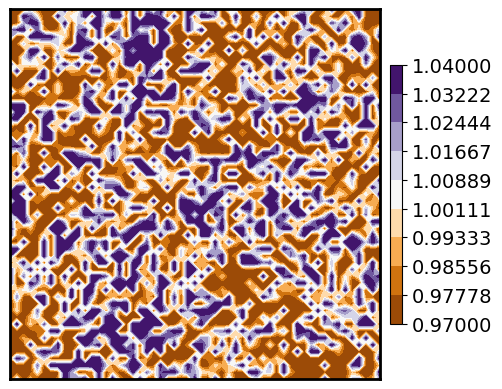

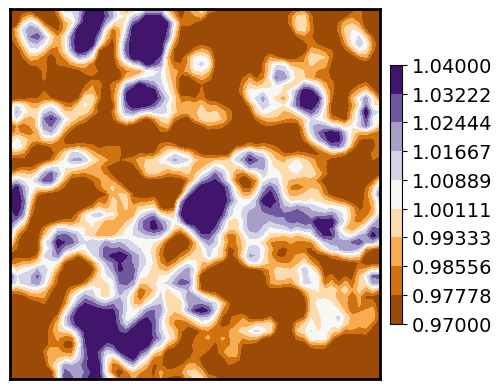

In [116]:
h = h_atom_up_mean_all_normed[-1]
im = plotDensmap4(h, edge3d) 
# im = plotDensmap_with_nan(h, edge3d) 
h = h_atom_up_mean_all_normed_filtered[-1]
im = plotDensmap4(h, edge3d) 
# im = plotDensmap_with_nan(h, edge3d) 

# 聚类

In [11]:
def plot_joint_density(data0, data1):
	# Step 3: 绘制分类后两类样本的二维联合分布图
	plt.figure(figsize=(3, 3))
	# Lo 类样本分布
	# plt.scatter(x=data1[:, 0], y=data1[:, 1], s=2, alpha=0.3, color = '#1f77b4')
	sns.kdeplot(x=data1[:, 0], y=data1[:, 1], cmap="Blues", fill=True, alpha=0.5, label="Lo")
	# Ld 类样本分布
	# plt.scatter(x=data0[:, 0], y=data0[:, 1], s=2, alpha=0.3, color = '#B22222')
	sns.kdeplot(x=data0[:, 0], y=data0[:, 1], cmap="Reds", fill=True, alpha=0.5, label="Ld")
	plt.xlabel("Normed density", fontsize=15)
	plt.ylabel("Primary lipid ratio", fontsize=15)
	plt.ylim(0, 1)
	plt.yticks(np.arange(0.2, 1.1, 0.2))
	
	plt.xlim(0.900, 1.075)
	plt.xticks(np.arange(0.90, 1.075, 0.05), fontsize=15)

	plt.tick_params(direction = 'in')
	
	# plt.legend()
	plt.show()

最优阈值: 1.003131313131313
最小loss: 0.5772628002026243


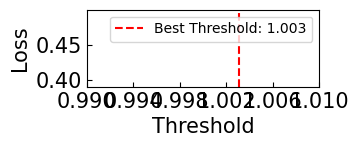

end of clustering all


In [52]:
def compute_loss(threshold, data, alpha = 1, beta = 1):
	# 将数据按阈值分成两类
	density_data = data[:, 0]
	# density_data = np.where (density_data <1.1, density_data, 1.1)
	# density_data = np.where (density_data >0.9, density_data, 0.9)
	lo_class = data[data[:, 0] >= threshold]  # 高密度的样本
	ld_class = data[data[:, 0] < threshold]   # 低密度的样本
	
	# 计算组内方差
	lo_variance = np.var(lo_class[:, 0]) if len(lo_class) > 0 else 0
	ld_variance = np.var(ld_class[:, 0]) if len(ld_class) > 0 else 0
	within_group_variance = (len(lo_class) * lo_variance * alpha + \
						  len(ld_class) * ld_variance * beta) / (len(lo_class) + len(ld_class))
	
	# 计算组间方差
	lo_mean = np.mean(lo_class[:, 0]) if len(lo_class) > 0 else 0
	ld_mean = np.mean(ld_class[:, 0]) if len(ld_class) > 0 else 0
	between_group_variance = (len(lo_class) * (lo_mean - np.mean(density_data))**2 + 
							  len(ld_class) * (ld_mean - np.mean(density_data))**2) / (len(lo_class) + len(ld_class))
	
	# 计算loss (组内方差/组间方差)
	loss = within_group_variance / between_group_variance if between_group_variance != 0 else float('inf')
	
	return loss
def plot_loss(thresholds, losses):
	# 可视化loss曲线
	plt.figure(figsize=(3, 1))
	plt.plot(thresholds, losses, linewidth = 2)
	plt.axvline(x=best_threshold, color='r', linestyle='--', \
			 label=f"Best Threshold: {best_threshold:.3f}")
	plt.xlim(0.99, 1.01)
	plt.xticks(np.arange(0.99, 1.01, 0.004), fontsize=15)
	plt.ylim(0.39, 0.50)
	plt.yticks(np.arange(0.40, 0.50, 0.05), fontsize=15)
	plt.tick_params(direction = 'in')
	plt.xlabel('Threshold', fontsize = 15)
	plt.ylabel('Loss', fontsize = 15)
	plt.legend()
	plt.show()
if (param == 'None'):

	# 阈值搜索
	# thresholds = np.linspace(1.02, 1.06, 100) ###
	thresholds = np.linspace(0.97, 1.01, 100) ##psm

	# 存储每个阈值对应的loss
	losses = [compute_loss(threshold, flattened_matrix, alpha = 1, beta = 1) for threshold in thresholds]

	# 找到最小loss的阈值
	best_threshold = thresholds[np.argmin(losses)]
	best_loss = min(losses)

	# 输出结果
	print(f"最优阈值: {best_threshold}")
	print(f"最小loss: {best_loss}")
	plot_loss(thresholds, losses)
	tags = np.where(list(flattened_matrix[:,0]) > best_threshold, 1, 0)

	# Step 3: 提取每个标签的联合分布参数
	output_data = {}
	output_data['density'] = {
			"mean":density_mean
		}
	output_data['phase'] = {
			"density Lo min": min(flattened_matrix[tags == 1, 0]),
			"density Ld max": max(flattened_matrix[tags == 0, 0]),
			"threshold": best_threshold
		}
	# print(output_data['phase'])
	with open(os.path.join(os.path.dirname(os.path.abspath(outpath)), 'parameters.json'), 'w') as json_file:
		json.dump(output_data, json_file, indent=4)

# 将标签数组重新分割为tag_up和tag_low，并还原其形状
split_idx = len(tags) // 2
tag_matrixs_up = tags[:split_idx].reshape(h_up_all.shape[0],h_up_all.shape[1],h_up_all.shape[2])
tag_matrixs_low = tags[split_idx:].reshape(h_up_all.shape[0],h_up_all.shape[1],h_up_all.shape[2])
# 在像素化平面针对grid的tag进行空间平滑
final_tag_matrixs_up = deepcopy(tag_matrixs_up)
final_tag_matrixs_low = deepcopy(tag_matrixs_low)
for n_fr in range(h_up_all.shape[0]):
	tag_matrix_up_fr = tag_matrixs_up[n_fr]
	tag_matrix_low_fr = tag_matrixs_low[n_fr]
	final_tag_matrixs_up[n_fr] = remove_isolated_points_and_smooth(tag_matrix_up_fr, iter=1) #控制是否平滑
	final_tag_matrixs_low[n_fr] = remove_isolated_points_and_smooth(tag_matrix_low_fr, iter=1) #控制是否平滑
print('end of clustering all')

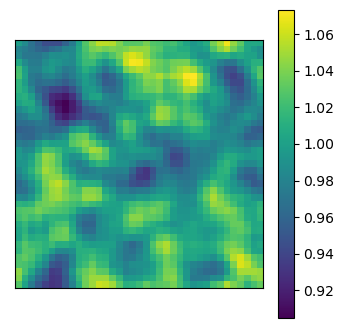

In [ ]:
h = h_atom_up_mean_all_normed_filtered[-1]
def plot_matrix(matrix, title="Matrix Plot", cmap='viridis'):
	# matrix = np.where (matrix <1.1, matrix, 1.1)
	# matrix = np.where (matrix >0.9, matrix, 0.9)
	"""
	使用指定的颜色映射绘制给定的n*m矩阵。
	
	参数:
	- matrix: 要绘制的二维numpy数组 (n, m)
	- title: 图像的标题，默认为 "Matrix Plot"
	- cmap: 使用的颜色映射，默认为 'viridis'
	"""
	rotated_matrix = np.flipud(np.transpose(matrix))
	plt.figure(figsize=(4, 4))
	# 使用imshow绘制矩阵，并应用颜色映射
	plt.imshow(rotated_matrix, cmap=cmap, origin='lower')
	plt.gca().invert_yaxis()  # 反转Y轴
	plt.colorbar()  # 添加颜色条以显示值的范围
	# 隐藏x轴和y轴的刻度
	plt.xticks([])
	plt.yticks([])
	plt.show()
plot_matrix(h, title="Matrix with NaN Values", cmap='viridis')

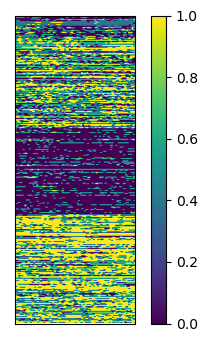

end of phase identification
shape of lips_tag:	 (200, 512)
---------------------------------



In [54]:
lips_tag = get_lipis_tags(tag_matrixs_up, tag_matrixs_low, lips_grid_ndx)
lips_tag = np.array(lips_tag)
lips_tag_smoothed = temporal_smoothing(lips_tag)
lips_tag_smoothed = np.array(lips_tag_smoothed)
plot_matrix(lips_tag_smoothed, title="Matrix with NaN Values", cmap='viridis')
print('end of phase identification')
print('shape of lips_tag:\t',lips_tag.shape)
print('---------------------------------\n')
outfn_raw = outpath+sys+'-rawdata.xvg'
outfn_upper_phase1 = outpath+sys+'-upper-phase1.xvg'
outfn_upper_phase2 = outpath+sys+'-upper-phase2.xvg'
outfn_lower_phase1 = outpath+sys+'-lower-phase1.xvg'
outfn_lower_phase2 = outpath+sys+'-lower-phase2.xvg'
outf_raw = open(outfn_raw, 'w')
outf_upper_phase1 = open(outfn_upper_phase1, 'w')
outf_upper_phase2 = open(outfn_upper_phase2, 'w')
outf_lower_phase1 = open(outfn_lower_phase1, 'w')
outf_lower_phase2 = open(outfn_lower_phase2, 'w')

lip_leaflet = []
for i in range(start,end,n_gap):
	fn_leaflets = lip_leaflet_raw[i:i+n_gap, :]
	most_common_leaflet_tag = [Counter(column).most_common(1)[0][0] for column in zip(*fn_leaflets)]
	lip_leaflet.append(most_common_leaflet_tag)
lip_leaflet = np.array(lip_leaflet)

for i in range(0, len(lips_tag_smoothed)):
	print('%d' % (start + 5*i),file=outf_raw,end=' ')
	for j in range(0, len(lips_tag_smoothed[0])):
		print('%d' % (lips_tag_smoothed[i][j]),file= outf_raw,end=' ')
	print('\n',file= outf_raw,end='')

for i in range(0, len(lips_tag_smoothed)):
	print('%d' % (start + 5*i),file=outf_upper_phase1,end=' ')
	print('%d' % (start + 5*i),file=outf_upper_phase2,end=' ')
	print('%d' % (start + 5*i),file=outf_lower_phase1,end=' ')
	print('%d' % (start + 5*i),file=outf_lower_phase2,end=' ')
	for j in range(0, len(lips_tag_smoothed[0])):
		if lips_tag_smoothed[i][j] == 0 and (lip_leaflet[i, j] == 0):
			print('%d' % (j+1),file=outf_upper_phase1,end=' ')
		elif lips_tag_smoothed[i][j] == 1 and (lip_leaflet[i, j] == 0):
			print('%d' % (j+1),file=outf_upper_phase2,end=' ')
		elif lips_tag_smoothed[i][j] == 0 and (lip_leaflet[i, j] == 1):
			print('%d' % (j+1), file=outf_lower_phase1, end=' ')
		elif lips_tag_smoothed[i][j] == 1 and (lip_leaflet[i, j] == 1):
			print('%d' % (j+1),file=outf_lower_phase2,end=' ')
	print( '\n',file=outf_upper_phase1,end='')
	print( '\n',file=outf_upper_phase2,end='')
	print( '\n',file=outf_lower_phase1,end='')
	print( '\n',file=outf_lower_phase2,end='')

# 画最后一us的图

In [24]:
b = 9000    #psm
e = 10000
inte = 5
bins = 2

up1file = outpath + sys + "-upper-phase1.xvg"
up2file = outpath + sys + "-upper-phase2.xvg"
low1file = outpath + sys + "-lower-phase1.xvg"
low2file = outpath + sys + "-lower-phase2.xvg"
with open(up1file, 'r') as file:
	up1 = [' '.join(line.strip().split(' ')[1:]) for line in file]
with open(up2file, 'r') as file:
	up2 = [' '.join(line.strip().split(' ')[1:]) for line in file]
with open(low1file, 'r') as file:
	low1 = [' '.join(line.strip().split(' ')[1:]) for line in file]
with open(low2file, 'r') as file:
	low2 = [' '.join(line.strip().split(' ')[1:]) for line in file]

def cal_densmap(sel, bin_x_num, bin_y_num, bin_z_num, box_x_ave, box_y_ave, box_z_ave, bins=0):
	#cal the box size of this frame
	box_fr = u.dimensions[:3]
	#get the coordinates of the selected atoms
	sel_atoms = u.select_atoms(sel).positions
	if(sel !=''):
		#move the com of system to the center of present box
		sel_all_com = u.select_atoms('all').center_of_mass()
		diffx = box_fr[0]/2 - sel_all_com[0]
		diffy = box_fr[1]/2 - sel_all_com[1]
		diffz = box_fr[2]/2 - sel_all_com[2]
		diffnp = np.array([diffx, diffy, diffz])
		sel_atoms_com = np.add(sel_atoms, diffnp)
		#rescale the coordinates between 0 - present boxsize
		#this step is low efficient, modify the code
		sel_atoms_pbc1 = np.where(sel_atoms_com > 0, sel_atoms_com, np.add(sel_atoms_com, box_fr))
		sel_atoms_pbc2 = np.where(sel_atoms_pbc1 < box_fr, sel_atoms_pbc1, np.add(sel_atoms_pbc1, -1*box_fr))
		#rescale the coordinates according to the average boxsize
		scale_np = np.array([box_x_ave / box_fr[0], box_y_ave / box_fr[1], box_z_ave / box_fr[2]])
		sel_atoms_scale = np.multiply(sel_atoms_pbc2, scale_np)
		#histogram the adjusted coordinates
		if bins == 0:
			h_fr, edge_fr = np.histogramdd(sel_atoms_scale, bins=(bin_x_num, bin_y_num, bin_z_num), normed = False)
		else:
			h_fr, edge_fr = np.histogramdd(sel_atoms_scale, bins=bins, normed = False)
	else:
		h_fr, edge_fr = np.histogramdd(np.empty((0, 3)), bins=bins, normed = False)
	#convert histogram to densities 
	volumn = (box_x_ave*box_y_ave*box_z_ave)/(bin_x_num*bin_y_num*bin_z_num)
	dens3d = h_fr / volumn
	#average along z axis to get 2D densmap
	dens2d = np.ndarray(shape = (dens3d.shape[0], dens3d.shape[1]), dtype = float)
	for i in range(0, dens3d.shape[0]):
		for j in range(0, dens3d.shape[1]):
			dens2d[i,j] = dens3d[i, j, :].mean()
	#return values
	return dens2d, edge_fr
def ratio_gel(hist0, hist1):
	#hist0, phase0; hist1, phase1;
	#0 in hist_comp present phase0
	hist_comp_old = np.zeros(hist0.shape)
	# 遍历每个元素
	for i in range(hist0.shape[0]):
		for j in range(hist0.shape[1]):
			if np.isnan(hist0[i, j]) and np.isnan(hist1[i, j]):
				hist_comp_old[i, j] = np.nan
			elif np.isnan(hist0[i, j]) and not np.isnan(hist1[i, j]):
				hist_comp_old[i, j] = 1 
			elif not np.isnan(hist0[i, j]) and np.isnan(hist1[i, j]):
				hist_comp_old[i, j] = 0
			elif hist0[i, j] == hist1[i, j]:
				hist_comp_old[i, j] = 9  # 如果两个值相等且不为 NaN，设置为 '9'
			elif hist0[i, j] > hist1[i, j]:
				hist_comp_old[i, j] = 0  # 如果 hist0 大于 hist1，设置为 0
			elif hist0[i, j] < hist1[i, j]:
				hist_comp_old[i, j] = 1  # 如果 hist0 大于 hist1，设置为 0
	### 去除x
	# 获取数组形状
	hist_comp = np.copy(hist_comp_old)
	rows, cols = hist_comp.shape
	# 遍历数组
	for i in range(rows):
		for j in range(cols):
			if hist_comp_old[i, j] == 9:  # 检查是否为 9
				# 获取周围 8 个元素，考虑周期性边界条件
				neighbors = [
					hist_comp_old[(i-1) % rows, (j-1) % cols],
					hist_comp_old[(i-1) % rows, j % cols],
					hist_comp_old[(i-1) % rows, (j+1) % cols],
					hist_comp_old[i % rows, (j-1) % cols],
					hist_comp_old[i % rows, (j+1) % cols],
					hist_comp_old[(i+1) % rows, (j-1) % cols],
					hist_comp_old[(i+1) % rows, j % cols],
					hist_comp_old[(i+1) % rows, (j+1) % cols]
				]
				# 统计出现次数的字典，忽略 NaN
				counts = {}
				for value in neighbors:
					if (not np.isnan(value)) and value != 9:  # 忽略 NaN和9
						counts[value] = counts.get(value, 0) + 1
				# 找到出现最多次的值
				max_count = -1
				most_frequent = None
				for key, count in counts.items():
					if count > max_count:
						max_count = count
						most_frequent = key
				# 替换 x
				hist_comp[i, j] = most_frequent
	count_p0 = np.sum(hist_comp == 0)
	return hist_comp, float(count_p0)/float(hist0.shape[0]*hist0.shape[1])
def ratio_regi(histu, histl):
	#histu, upper leaflet; histl, lower leaflet;
	#0 both phase0, 1 both phase1, 0.25 upper phase0 lower phase1, 0.75 upper phase1 lower phase0
	hist_comp = np.full_like(histu, np.nan)
	count = [0, 0, 0, 0] # both phase0, both phase1, upper phase0 lower phase1, lower phase0 upper phase1
	for i in range(0, histu.shape[0]):
		for j in range(0, histu.shape[1]):
			if histu[i, j] == 0 and histl[i, j] == 0:
				hist_comp[i, j] = 0
				count[0]+=1.0
			elif histu[i, j] == 1 and histl[i, j] == 1:
				hist_comp[i, j] = 1
				count[1]+=1.0
			elif histu[i, j] == 0 and histl[i, j] == 1:
				hist_comp[i, j] = 0.25
				count[2]+=1.0
			elif histu[i, j] == 1 and histl[i, j] == 0:
				hist_comp[i, j] = 0.75
				count[3]+=1.0
 
	ratio = np.array(count)/float(histu.shape[0]*histl.shape[1])

	return hist_comp, ratio
#read the trajectory for cal
u = MDAnalysis.Universe(pdb, trj)
#cal the average size of the box,
print ("calculating the average size of the box ... ")
box_x = 0
box_y = 0
box_z = 0
count = 0
for ts in u.trajectory[b:e:inte]:
	box = ts.dimensions[:3]
	box_x += box[0]
	box_y += box[1]
	box_z += box[2]
	count += 1
box_x_ave = box_x / float(count)
box_y_ave = box_y / float(count)
box_z_ave = box_z / float(count)
#cal the num of bins
bin_x_num = int(box_x_ave / bins)
bin_y_num = int(box_y_ave / bins)
bin_z_num = int(box_z_ave / bins)
outf_ratio = open(outpath+sys+'-ratio.xvg', 'w')
h_up_list = []; e_list = []
h_low_list = [];
h_list=[]
for ts in u.trajectory[b:e:inte]:
	index = int((ts.frame-b)/inte) 
	sel_up1 = 'resid ' + up1[index]
	sel_up2 = 'resid ' + up2[index]
	sel_lp1 = 'resid ' + low1[index]
	sel_lp2 = 'resid ' + low2[index]

	hist_all, edge_fr = cal_densmap('all', bin_x_num, bin_y_num, bin_z_num, box_x_ave, box_y_ave, box_z_ave)

	hist_up1, _ = cal_densmap(sel_up1, bin_x_num, bin_y_num, bin_z_num, box_x_ave, box_y_ave, box_z_ave, bins=edge_fr) if len(sel_up1) != 6 else (np.zeros_like(hist_all), edge_fr)
	hist_up2, _ = cal_densmap(sel_up2, bin_x_num, bin_y_num, bin_z_num, box_x_ave, box_y_ave, box_z_ave, bins=edge_fr) if len(sel_up2) != 6 else (np.zeros_like(hist_all), edge_fr)
	hist_lp1, _ = cal_densmap(sel_lp1, bin_x_num, bin_y_num, bin_z_num, box_x_ave, box_y_ave, box_z_ave, bins=edge_fr) if len(sel_lp1) != 6 else (np.zeros_like(hist_all), edge_fr)
	hist_lp2, _ = cal_densmap(sel_lp2, bin_x_num, bin_y_num, bin_z_num, box_x_ave, box_y_ave, box_z_ave, bins=edge_fr) if len(sel_lp2) != 6 else (np.zeros_like(hist_all), edge_fr)

	#cal ratio of gel/lo phase in each leaflet
	p0_hist_u, p0_ratio_u = ratio_gel(hist_up1, hist_up2)
	p0_hist_l, p0_ratio_l = ratio_gel(hist_lp1, hist_lp2)
	#cal ratio of registration
	regi_hist, regi_ratio = ratio_regi(p0_hist_u, p0_hist_l)

	h_up_list.append(p0_hist_u)
	h_low_list.append(p0_hist_l)
	h_list.append(regi_hist)
	e_list.append(edge_fr)
	print ('%d %.4f %.4f %.4f %.4f %.4f %.4f' % (\
			ts.frame, p0_ratio_u, p0_ratio_l, regi_ratio[0], regi_ratio[1], regi_ratio[2], regi_ratio[3]), file=outf_ratio),
	
 
print("Finish calculating!")


calculating the average size of the box ... 
Finish calculating!


In [25]:
from matplotlib.colors import ListedColormap, BoundaryNorm

def plotDensmap(h, e):
	normData = h.copy()
	cmap = ListedColormap([
				(177/255, 24/255, 43/255),    # 红
				(223/255, 118/255, 94/255), # 橘
				(1,1,1), #white
				(92/255, 163/255, 203/255), # 浅蓝
				(32/255, 101/255, 171/255),   # 蓝
			])
	cmap.set_bad(color='black')  # NaN 为白色
	# 构造等级，必须是值的“边界”
	# 注意：两个值 -> 需要三个 levels 表示两个区间
	levels = [0.0, 0.20, 0.30, 0.70, 0.8, 1.0]  # 任意，只要能将两个值分开就行

	# 构建 BoundaryNorm：用于让 contourf 不插值，严格两个颜色
	norm = BoundaryNorm(boundaries=levels, ncolors=cmap.N)

	xMatrix = np.zeros((normData.shape[0], normData.shape[1]))
	yMatrix = np.zeros((normData.shape[0], normData.shape[1]))
	xaxis = e[0][1:]
	yaxis = e[1][1:]
	for i in range(0, normData.shape[0]):
		xMatrix[i, :] = xaxis
	for j in range(0, normData.shape[1]):
		yMatrix[:, j] = yaxis
	# im = plt.contourf(yMatrix,
	# 			xMatrix, normData, norm = norm,
	# 			cmap=cmap, levels = levels)
	# im = plt.pcolormesh(yMatrix, xMatrix, normData, cmap=cmap, norm=norm)
	im = plt.contourf(yMatrix, xMatrix, normData, levels=levels, cmap=cmap, norm=norm)
	# im = plt.imshow(normData, cmap=cmap, interpolation='nearest')
	densmap = plt.gca()
	densmap.set_aspect(1)
	#set border width
	densmap.spines['bottom'].set_linewidth(2)
	densmap.spines['left'].set_linewidth(2)
	densmap.spines['top'].set_linewidth(2)
	densmap.spines['right'].set_linewidth(2)
	densmap.tick_params(axis='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
	return im
# for i in range(1): #看最后20ns 每5ns一输出
for i in range(len(h_up_list)): #看最后20ns 每5ns一输出
	fig1 = plt.figure(figsize=(3, 3.5))
	h_up = h_up_list[i]
	e_up = e_list[i]
	h_low = h_low_list[i]
	e_low = e_list[i]
	h = h_list[i]

	im = plotDensmap(h_up, e_up)
	# fig1.suptitle('Quaternary mixture 300 K'+'\nupper ts = ' + str(b+i*5) +'ns')
	fig1.suptitle('Binary mixture 280 K'+'\nupper ts = ' + str(b+i*5) +'ns')
	# fig1.suptitle('Binary mixture 280 K with 1j4n'+'\nupper ts = ' + str(b+i*5) +'ns')
	fig1.savefig(outpath+"phaseplot/upper/"+sys+'-'+str(b+i*5)+'-upper.png', 
				dpi=350,
				format='png',        # 文件格式
				bbox_inches='tight', # 自动调整边界框
				pad_inches=0.0,      # 边界填充
				# facecolor='white',   # 背景颜色
				# edgecolor='black',   # 边缘颜色
				transparent=False,   # 是否透明背景
				# metadata={'Author': 'Your Name'}  # 元数据)
				)
	
	# im = plotDensmap(h_low, e_low)
	# fig1.suptitle('Quaternary mixture 300 K'+'\nlower ts = ' + str(b+i*5) +'ns')
	# # fig1.suptitle('Binary mixture 280 K with 1j4n'+'\nlower ts = ' + str(b+i*5) +'ns')
	# fig1.savefig(outpath+"phaseplot/lower/"+sys+'-'+str(b+i*5)+'-lower.png', 
	# 			dpi=350,
	# 			format='png',        # 文件格式
	# 			bbox_inches='tight', # 自动调整边界框
	# 			pad_inches=0.0,      # 边界填充
	# 			# facecolor='white',   # 背景颜色
	# 			# edgecolor='black',   # 边缘颜色
	# 			transparent=False,   # 是否透明背景
	# 			# metadata={'Author': 'Your Name'}  # 元数据)
	# 			)

	im = plotDensmap(h, e_low)
	fig1.suptitle('Binary mixture 280 K'+'\nregi ts = ' + str(b+i*5) +'ns')
	fig1.savefig(outpath+"phaseplot/regi/"+sys+'-'+str(b+i*5)+'.png', 
				dpi=350,
				format='png',        # 文件格式
				bbox_inches='tight', # 自动调整边界框
				pad_inches=0.0,      # 边界填充
				# facecolor='white',   # 背景颜色
				# edgecolor='black',   # 边缘颜色
				transparent=False,   # 是否透明背景
				# metadata={'Author': 'Your Name'}  # 元数据)
				)
	# im = plotDensmap(h, e_low)
	# fig1.suptitle('The ternary mixture at 280 K'+' ts = ' + str(b+i*5-1000) +' ns',fontweight='bold')
	# fig1.savefig(phasepath+"phaseplot/regi/"+sys+'-'+str(b+i*5-1000)+'.png', 
	#             dpi=350,
	#             format='png',        # 文件格式
	#             bbox_inches='tight', # 自动调整边界框
	#             pad_inches=0.0,      # 边界填充
	#             # facecolor='white',   # 背景颜色
	#             # edgecolor='black',   # 边缘颜色
	#             transparent=False,   # 是否透明背景
	#             # metadata={'Author': 'Your Name'}  # 元数据)
	#             )
	plt.close()
print("Finish plotting!")

Finish plotting!


# 一个自动化计算的版本

In [105]:
import numpy as np
# sys = 'dpdo280k'
# scd_file = '/data/gulab/yzdai/data4/atomdensity/plot_data/last1us_gap5_scd_area/'+sys+'_scd.xvg'
# scd_all = np.loadtxt(scd_file)[:,:]
# print(scd_all.shape)
# area_file = '/data/gulab/yzdai/data4/atomdensity/plot_data/last1us_gap5_scd_area/'+sys+'_area.xvg'
# area_all = np.loadtxt(area_file)[:,1:]
# print(area_all.shape)
# dopc_id = list(range(347, 577)) + list(range(923, 1153))
# dppc_id = list(range(1, 347)) + list(range(577, 923))

sys = 'dpdochl290k'
# sys = 'dpdochl280k'

scd_file = '/data/gulab/yzdai/data4/atomdensity/plot_data/last1us_gap5_scd_area/'+sys+'_scd.xvg'
scd = list(np.loadtxt(scd_file)[:,:])
scd_all = np.array([list(x[:404]) + [0]*172 + list(x[404:]) +[0]*172 for x in scd])
print(scd_all.shape)
dopc_id = list(range(203, 405)) + list(range(779, 981))
chol_id = list(range(405, 577)) + list(range(981, 1153))
dppc_id = list(range(1, 203)) + list(range(577, 779))

(200, 1152)


In [106]:
from scipy.optimize import minimize_scalar
import numpy as np
from scipy.stats import entropy
import time
def kl_normal(mu1, std1, mu2, std2):
	return np.log(std2 / std1) + (std1**2 + (mu1 - mu2)**2) / (2 * std2**2) - 0.5

def gaussian_js_divergence(scd_lo, scd_ld):
	mu_lo, std_lo = np.mean(scd_lo), np.std(scd_lo)
	mu_ld, std_ld = np.mean(scd_ld), np.std(scd_ld)
	
	# Mixture mean/std can be estimated as average (not exact but works)
	mu_m = 0.5 * (mu_lo + mu_ld)
	std_m = 0.5 * (std_lo + std_ld)

	js = 0.5 * kl_normal(mu_lo, std_lo, mu_m, std_m) + \
		 0.5 * kl_normal(mu_ld, std_ld, mu_m, std_m)
	return js

def extract_scd_by_phase_vectorized(lips_tag_smoothed, scd_all, dppc_id):
	# 转为 numpy array
	dppc_id = np.array(dppc_id)

	# 构造一个 lipid index matrix：shape (n_frame, n_lipid)
	n_frame, n_lipid = lips_tag_smoothed.shape
	lipid_ids = np.arange(1, n_lipid + 1)  # 原本你是从 lip = l + 1

	# 构造一个 mask，标记哪些 lipid 是 DPPC
	dppc_mask = np.isin(lipid_ids, dppc_id)  # shape (n_lipid,)

	# 将 mask 广播到所有帧 → shape (n_frame, n_lipid)
	dppc_mask_2d = np.tile(dppc_mask, (n_frame, 1))

	# 筛选出 DPPC 部分的标签和 SCD
	phase_tags = lips_tag_smoothed[dppc_mask_2d]
	scd_values = scd_all[dppc_mask_2d]

	# 根据 phase tag 分离
	scd_ld = scd_values[phase_tags == 0]
	scd_lo = scd_values[phase_tags == 1]

	return scd_ld, scd_lo

def compute_js_for_threshold(threshold, flattened_matrix, shape, lips_grid_ndx, scd_all, dppc_id):
	t0 = time.time()
	# Phase tagging
	tags = np.where(flattened_matrix[:,0] > threshold, 1, 0)
	split_idx = len(tags) // 2
	tag_matrixs_up = tags[:split_idx].reshape(shape)
	tag_matrixs_low = tags[split_idx:].reshape(h_up_all.shape)
	# print(f"[{threshold:.4f}] Phase tagging: {time.time() - t0:.2f}s")

	# # 2. Spatial smoothing
	# t1 = time.time()
	# final_tag_matrixs_up = np.zeros_like(tag_matrixs_up)
	# final_tag_matrixs_low = np.zeros_like(tag_matrixs_low)
	# for n_fr in range(h_up_all.shape[0]):
	# 	final_tag_matrixs_up[n_fr] = remove_isolated_points_and_smooth(tag_matrixs_up[n_fr], iter=1)
	# 	final_tag_matrixs_low[n_fr] = remove_isolated_points_and_smooth(tag_matrixs_low[n_fr], iter=1)
	# print(f"[{threshold:.4f}] Spatial smoothing: {time.time() - t1:.2f}s")

	# 3. Tag extraction and temporal smoothing
	t2 = time.time()
	# lips_tag = get_lipis_tags(final_tag_matrixs_up, final_tag_matrixs_low, lips_grid_ndx)
	lips_tag = get_lipis_tags(tag_matrixs_up, tag_matrixs_low, lips_grid_ndx)
	lips_tag_smoothed = np.array(temporal_smoothing(np.array(lips_tag)))
	# print(f"[{threshold:.4f}] Temporal smoothing: {time.time() - t2:.2f}s")

	# 4. JS
	t3 = time.time()
	scd_ld, scd_lo = extract_scd_by_phase_vectorized(lips_tag_smoothed, scd_all, dppc_id)
	scd_ld_dopc, scd_lo_dopc = extract_scd_by_phase_vectorized(lips_tag_smoothed, scd_all, dopc_id)
	if len(scd_ld) < 10 or len(scd_lo) < 10:
		js = 0
	else:
		js = gaussian_js_divergence(scd_lo, scd_ld)
	if len(scd_ld_dopc) < 10 or len(scd_lo_dopc) < 10:
		js_dopc = 0
	else:
		js_dopc = gaussian_js_divergence(scd_lo_dopc, scd_ld_dopc)
	# print(f"[{threshold:.4f}] JS calc: {time.time() - t3:.2f}s")
	return threshold, js_dopc
	# return threshold, js+js_dopc

  3%|▎         | 1/30 [00:28<13:33, 28.04s/it]

[Done ] threshold=0.9872 in 28.06s
[Done ] threshold=0.9921 in 28.13s


 13%|█▎        | 4/30 [00:29<02:11,  5.06s/it]

[Done ] threshold=0.9848 in 28.96s
[Done ] threshold=0.9800 in 29.28s


 17%|█▋        | 5/30 [00:30<01:32,  3.70s/it]

[Done ] threshold=0.9824 in 30.34s


 20%|██        | 6/30 [00:50<03:33,  8.90s/it]

[Done ] threshold=0.9897 in 50.10s


 27%|██▋       | 8/30 [00:57<02:09,  5.88s/it]

[Done ] threshold=1.0017 in 28.16s
[Done ] threshold=0.9993 in 28.79s


 37%|███▋      | 11/30 [00:58<00:40,  2.12s/it]

[Done ] threshold=1.0041 in 27.96s
[Done ] threshold=0.9969 in 30.23s
[Done ] threshold=0.9945 in 30.63s


 40%|████      | 12/30 [01:17<02:11,  7.33s/it]

[Done ] threshold=1.0066 in 27.66s


 43%|████▎     | 13/30 [01:27<02:17,  8.09s/it]

[Done ] threshold=1.0090 in 30.19s


 47%|████▋     | 14/30 [01:27<01:32,  5.76s/it]

[Done ] threshold=1.0162 in 29.87s


 50%|█████     | 15/30 [01:29<01:05,  4.34s/it]

[Done ] threshold=1.0186 in 30.33s


 53%|█████▎    | 16/30 [01:29<00:45,  3.28s/it]

[Done ] threshold=1.0138 in 31.69s


 57%|█████▋    | 17/30 [01:35<00:51,  3.97s/it]

[Done ] threshold=1.0114 in 38.17s


 60%|██████    | 18/30 [01:47<01:18,  6.55s/it]

[Done ] threshold=1.0210 in 30.50s


 67%|██████▋   | 20/30 [01:55<00:49,  4.91s/it]

[Done ] threshold=1.0234 in 28.26s
[Done ] threshold=1.0259 in 27.79s


 70%|███████   | 21/30 [01:58<00:37,  4.19s/it]

[Done ] threshold=1.0283 in 29.51s


 73%|███████▎  | 22/30 [02:00<00:27,  3.45s/it]

[Done ] threshold=1.0307 in 30.44s


 77%|███████▋  | 23/30 [02:13<00:45,  6.53s/it]

[Done ] threshold=1.0331 in 37.23s


 80%|████████  | 24/30 [02:14<00:28,  4.75s/it]

[Done ] threshold=1.0355 in 26.30s


 87%|████████▋ | 26/30 [02:24<00:17,  4.47s/it]

[Done ] threshold=1.0428 in 25.83s
[Done ] threshold=1.0403 in 28.66s


 90%|█████████ | 27/30 [02:25<00:09,  3.23s/it]

[Done ] threshold=1.0379 in 29.06s


 93%|█████████▎| 28/30 [02:25<00:04,  2.46s/it]

[Done ] threshold=1.0452 in 25.24s


 97%|█████████▋| 29/30 [02:29<00:02,  2.89s/it]

[Done ] threshold=1.0476 in 15.52s


100%|██████████| 30/30 [02:32<00:00,  5.07s/it]


[Done ] threshold=1.0500 in 17.18s
Best threshold: 1.0475862068965518
Maximum JS divergence: 0.6764075453600654


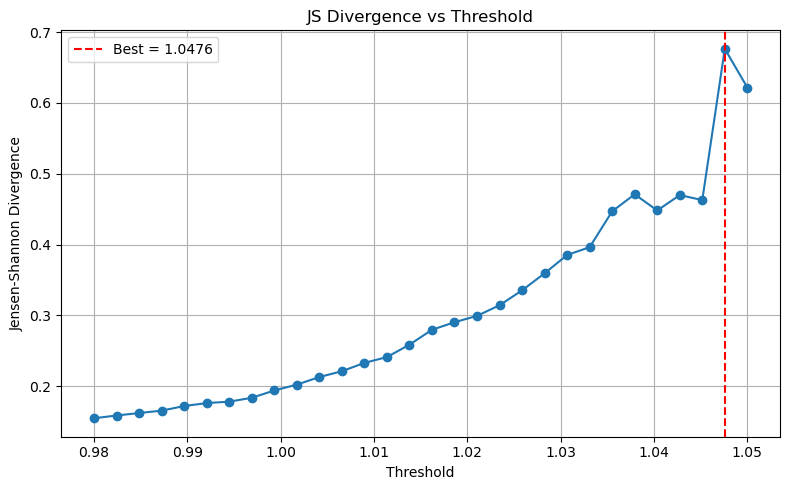

In [40]:
import matplotlib.pyplot as plt
from joblib import Parallel, delayed, parallel_backend
from tqdm import tqdm
from multiprocessing import Lock
import time

shape = (n_t,n_x,n_y)
def wrapped_compute(t, *args):
	# with lock:
	# 	print(f"[Start] threshold={t:.4f}")
	t0 = time.time()
	
	result = compute_js_for_threshold(t, *args)
	
	with lock:
		pbar.update(1)
		print(f"[Done ] threshold={t:.4f} in {time.time() - t0:.2f}s")
	return result
if (param == 'None'):
	thresholds = np.linspace(0.98, 1.05, 30)

	lock = Lock()
	pbar = tqdm(total=len(thresholds))


	with parallel_backend('threading', n_jobs=6):
		results = Parallel()(
			delayed(wrapped_compute)(t, flattened_matrix, shape, lips_grid_ndx, scd_all, dppc_id)
			for t in thresholds
		)

	pbar.close()


	# 3. 提取 threshold 和对应 JS 散度
	thresholds_out, js_values = zip(*results)
	thresholds_out = np.array(thresholds_out)
	js_values = np.array(js_values)

	# 4. 找到最大值
	best_idx = np.argmax(js_values)
	best_threshold = thresholds_out[best_idx]
	max_js = js_values[best_idx]

	print("Best threshold:", best_threshold)
	print("Maximum JS divergence:", max_js)

	# 5. 可视化（可选）
	plt.figure(figsize=(8,5))
	plt.plot(thresholds_out, js_values, marker='o')
	plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best = {best_threshold:.4f}')
	plt.xlabel('Threshold')
	plt.ylabel('Jensen-Shannon Divergence')
	plt.title('JS Divergence vs Threshold')
	plt.grid(True)
	plt.legend()
	plt.tight_layout()
	plt.show()
	# Step 3: 提取每个标签的联合分布参数
	output_data = {}
	output_data['density'] = {
			"mean":density_mean
		}
	output_data['phase'] = {
			"threshold": best_threshold
		}
	# print(output_data['phase'])
	with open(os.path.join(os.path.dirname(os.path.abspath(outpath)), 'parameters.json'), 'w') as json_file:
		json.dump(output_data, json_file, indent=4)
else:
	with open(param, 'r') as json_file:
		params = json.load(json_file)
	best_threshold = params['phase']['threshold']

In [16]:
import gc
gc.collect()


3869

In [96]:
tags = np.where(list(flattened_matrix[:,0]) > best_threshold, 1, 0)
# 将标签数组重新分割为tag_up和tag_low，并还原其形状
split_idx = len(tags) // 2
tag_matrixs_up = tags[:split_idx].reshape(n_t, n_x, n_y)
tag_matrixs_low = tags[split_idx:].reshape(n_t, n_x, n_y)

lips_tag = get_lipis_tags(tag_matrixs_up, tag_matrixs_low, lips_grid_ndx)
lips_tag = np.array(lips_tag)
lips_tag_smoothed = temporal_smoothing(lips_tag)
lips_tag_smoothed = np.array(lips_tag_smoothed)

print('end of phase identification')
print('shape of lips_tag:\t',lips_tag.shape)
print('---------------------------------\n')
outfn_raw = outpath+sys+'-rawdata.xvg'
outfn_upper_phase1 = outpath+sys+'-upper-phase1.xvg'
outfn_upper_phase2 = outpath+sys+'-upper-phase2.xvg'
outfn_lower_phase1 = outpath+sys+'-lower-phase1.xvg'
outfn_lower_phase2 = outpath+sys+'-lower-phase2.xvg'
outf_raw = open(outfn_raw, 'w')
outf_upper_phase1 = open(outfn_upper_phase1, 'w')
outf_upper_phase2 = open(outfn_upper_phase2, 'w')
outf_lower_phase1 = open(outfn_lower_phase1, 'w')
outf_lower_phase2 = open(outfn_lower_phase2, 'w')

lip_leaflet = []
for i in range(start,end,n_gap):
	fn_leaflets = lip_leaflet_raw[i:i+n_gap, :]
	most_common_leaflet_tag = [Counter(column).most_common(1)[0][0] for column in zip(*fn_leaflets)]
	lip_leaflet.append(most_common_leaflet_tag)
lip_leaflet = np.array(lip_leaflet)

for i in range(0, len(lips_tag_smoothed)):
	print('%d' % (start + 5*i),file=outf_raw,end=' ')
	for j in range(0, len(lips_tag_smoothed[0])):
		print('%d' % (lips_tag_smoothed[i][j]),file= outf_raw,end=' ')
	print('\n',file= outf_raw,end='')

for i in range(0, len(lips_tag_smoothed)):
	print('%d' % (start + 5*i),file=outf_upper_phase1,end=' ')
	print('%d' % (start + 5*i),file=outf_upper_phase2,end=' ')
	print('%d' % (start + 5*i),file=outf_lower_phase1,end=' ')
	print('%d' % (start + 5*i),file=outf_lower_phase2,end=' ')
	for j in range(0, len(lips_tag_smoothed[0])):
		if lips_tag_smoothed[i][j] == 0 and (lip_leaflet[i, j] == 0):
			print('%d' % (j+1),file=outf_upper_phase1,end=' ')
		elif lips_tag_smoothed[i][j] == 1 and (lip_leaflet[i, j] == 0):
			print('%d' % (j+1),file=outf_upper_phase2,end=' ')
		elif lips_tag_smoothed[i][j] == 0 and (lip_leaflet[i, j] == 1):
			print('%d' % (j+1), file=outf_lower_phase1, end=' ')
		elif lips_tag_smoothed[i][j] == 1 and (lip_leaflet[i, j] == 1):
			print('%d' % (j+1),file=outf_lower_phase2,end=' ')
	print( '\n',file=outf_upper_phase1,end='')
	print( '\n',file=outf_upper_phase2,end='')
	print( '\n',file=outf_lower_phase1,end='')
	print( '\n',file=outf_lower_phase2,end='')

end of phase identification
shape of lips_tag:	 (200, 1152)
---------------------------------



# GMM

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.optimize import brentq
from sklearn.metrics import silhouette_score
def score_threshold(data, threshold):
    tags = (data > threshold).astype(int)
    lo = data[tags == 1]
    ld = data[tags == 0]

    if len(lo) < 10 or len(ld) < 10:
        return 0

    mu_lo = np.mean(lo)
    mu_ld = np.mean(ld)
    var_lo = np.var(lo)
    var_ld = np.var(ld)

    fisher_score = (mu_lo - mu_ld)**2 / (var_lo + var_ld + 1e-8)
    return fisher_score

    # tags = (data > threshold).astype(int)
    # lo = data[tags == 1]
    # ld = data[tags == 0]

    # if len(lo) < 10 or len(ld) < 10:
    #     return 0

    # mu_lo = np.mean(lo)
    # mu_ld = np.mean(ld)
    # var_lo = np.var(lo)
    # var_ld = np.var(ld)

    # term1 = 0.25 * np.log(0.25 * ((var_lo / var_ld) + (var_ld / var_lo) + 2))
    # term2 = 0.25 * ((mu_lo - mu_ld) ** 2) / (var_lo + var_ld + 1e-8)
    # bd_score = term1 + term2

    # return bd_score  # 越大分离越好
    # return score  # 越大越好

def get_best_gmm_threshold(data_1d, plot=True):
    """
    自动选择最优 GMM 阈值（intersection / mean / weighted / hybrid）

    返回：
        best_threshold: 最优分类阈值
        all_scores: dict 各策略对应分数
    """
    X = data_1d[~np.isnan(data_1d)].reshape(-1, 1)
    gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
    gmm.fit(X)

    means = gmm.means_.flatten()
    stds = np.sqrt(gmm.covariances_.flatten())
    weights = gmm.weights_.flatten()

    # 保证顺序：means[0] 是 Ld，means[1] 是 Lo
    if means[0] > means[1]:
        means = means[::-1]
        stds = stds[::-1]
        weights = weights[::-1]

    # 尝试获取交点
    try:
        def f(x): return weights[0]*norm.pdf(x, means[0], stds[0]) - weights[1]*norm.pdf(x, means[1], stds[1])
        intersection = brentq(f, means[0], means[1])
    except:
        intersection = np.mean(means)  # fallback

    # 所有候选阈值
    candidates = {
        "intersection": intersection,
        "mean": np.mean(means),
        "weighted": np.dot(means, weights),
        "hybrid": 0.5 * intersection + 0.5 * np.mean(means)
    }

    # 对每个阈值计算得分
    scores = {k: score_threshold(X.ravel(), v) for k, v in candidates.items()}
    best_key = max(scores, key=scores.get)
    best_threshold = candidates[best_key]

    if plot:
        x = np.linspace(X.min(), X.max(), 1000)
        p0 = weights[0] * norm.pdf(x, means[0], stds[0])
        p1 = weights[1] * norm.pdf(x, means[1], stds[1])
        total = p0 + p1

        plt.figure(figsize=(7,4))
        plt.hist(X, bins=100, density=True, alpha=0.4, label='Density Histogram')
        plt.plot(x, p0, label=f'G1 (mean={means[0]:.3f})', color='C1')
        plt.plot(x, p1, label=f'G2 (mean={means[1]:.3f})', color='C0')
        plt.plot(x, total, '--', color='k', label='Total GMM fit')

        for k, v in candidates.items():
            plt.axvline(v, linestyle='--', alpha=0.5, label=f"{k}: {v:.3f}")

        plt.axvline(best_threshold, color='r', linestyle='-', lw=2, label=f"Best: {best_key}")
        plt.xlabel("Atomic Density")
        plt.ylabel("Probability Density")
        plt.title("GMM Threshold Selection (Auto)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return best_threshold, scores


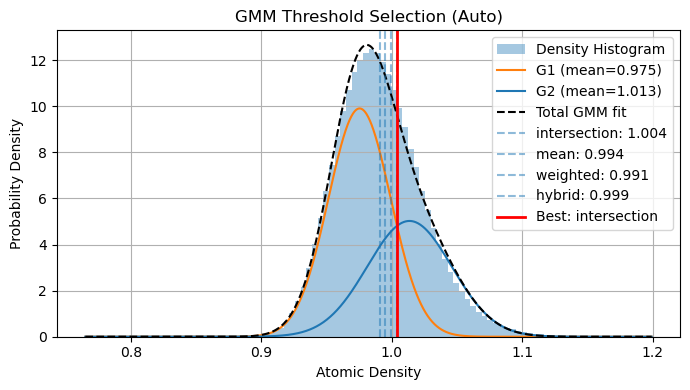

✅ 最优阈值：1.0039
{'intersection': 3.530973020601083, 'mean': 3.3140822740835163, 'weighted': 3.2532296396384974, 'hybrid': 3.4133449350958043}


In [118]:
best_threshold, all_scores = get_best_gmm_threshold(flattened_matrix[:, 0])
print(f"✅ 最优阈值：{best_threshold:.4f}")
print(all_scores)


In [93]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def get_gmm_weighted_threshold(data_1d, plot=True):
    """
    使用 GMM 拟合密度分布，并返回加权均值作为分类阈值。

    参数：
        data_1d: 一维密度数据，可含 NaN
        plot: 是否可视化拟合与阈值

    返回：
        threshold: 加权均值阈值
    """
    x = data_1d[~np.isnan(data_1d)].reshape(-1, 1)
    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(x)

    means = gmm.means_.flatten()
    stds = np.sqrt(gmm.covariances_.flatten())
    weights = gmm.weights_.flatten()

    # 保证 Ld 在前（小的 mean）
    if means[0] > means[1]:
        means = means[::-1]
        stds = stds[::-1]
        weights = weights[::-1]

    # 计算加权均值阈值
    threshold = np.dot(means, weights)

    if plot:
        X = np.linspace(x.min(), x.max(), 1000)
        p0 = weights[0] * norm.pdf(X, means[0], stds[0])
        p1 = weights[1] * norm.pdf(X, means[1], stds[1])
        total = p0 + p1

        plt.figure(figsize=(7, 4))
        plt.hist(x, bins=100, density=True, alpha=0.4, label='Density Histogram')
        plt.plot(X, p0, label=f'G0 (mean={means[0]:.3f})', color='C1')
        plt.plot(X, p1, label=f'G1 (mean={means[1]:.3f})', color='C0')
        plt.plot(X, total, '--', color='k', label='Total GMM Fit')
        plt.axvline(threshold, color='r', linestyle='--', label=f'Weighted Threshold = {threshold:.3f}')
        plt.xlabel("Atomic Density")
        plt.ylabel("Probability Density")
        plt.title("GMM Threshold (Weighted Mean)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return threshold


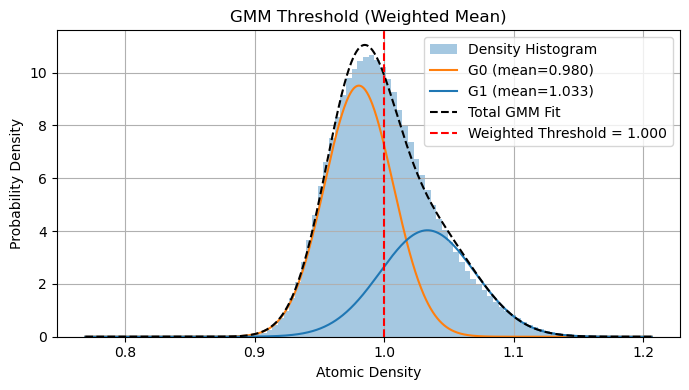

📌 GMM Weighted Threshold: 1.0000


In [94]:
best_threshold = get_gmm_weighted_threshold(flattened_matrix[:, 0])
print(f"📌 GMM Weighted Threshold: {best_threshold:.4f}")


In [97]:
print(best_threshold)

1.0000000003377914


# otsu

In [62]:
import numpy as np
import matplotlib.pyplot as plt

def otsu_threshold_1d(data_1d, bins=256, plot=True):
    """
    对一维密度数据使用 Otsu 方法（纯 NumPy），返回最佳分类阈值。
    
    参数：
        data_1d: 一维 numpy 数组（原子密度），可以包含 NaN
        bins: 分箱数（默认256）
        plot: 是否可视化

    返回：
        best_thresh: 最优阈值
    """

    # 去除 NaN
    data = data_1d[~np.isnan(data_1d)]

    # 计算直方图
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # 累积分布
    weight_cumsum = np.cumsum(hist)
    mean_cumsum = np.cumsum(hist * bin_centers)

    total_mean = mean_cumsum[-1]

    inter_class_var = ((total_mean * weight_cumsum - mean_cumsum) ** 2) / \
                      (weight_cumsum * (1 - weight_cumsum) + 1e-10)  # 防除零

    best_index = np.argmax(inter_class_var)
    best_thresh = bin_centers[best_index]

    # 可视化
    if plot:
        plt.figure(figsize=(7, 4))
        plt.hist(data, bins=bins, density=True, alpha=0.5, color='gray', label='Density Histogram')
        plt.axvline(best_thresh, color='r', linestyle='--', label=f'Otsu Threshold = {best_thresh:.3f}')
        plt.xlabel("Atomic Density")
        plt.ylabel("Probability Density")
        plt.title("Otsu Threshold (1D, NumPy version)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return best_thresh


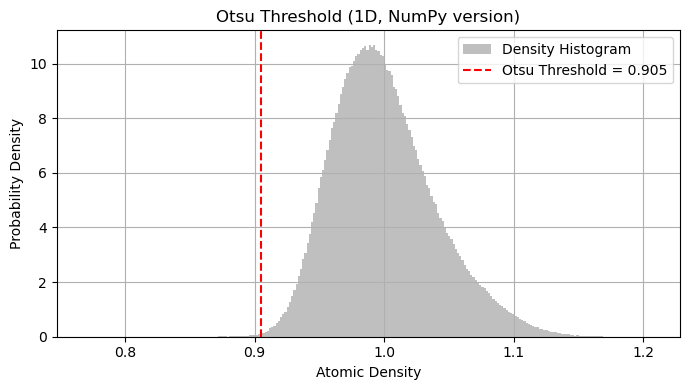

📌 最优 Otsu 阈值为：0.9052


In [63]:
best_threshold = otsu_threshold_1d(flattened_matrix[:, 0], plot=True)
print(f"📌 最优 Otsu 阈值为：{best_threshold:.4f}")


# 输出

In [99]:
if (param == 'None'):
	output_data = {}
	output_data['density'] = {
			"mean":density_mean
		}
	output_data['phase'] = {
			"threshold": best_threshold
		}
	# print(output_data['phase'])
	with open(os.path.join(os.path.dirname(os.path.abspath(outpath)), 'parameters.json'), 'w') as json_file:
		json.dump(output_data, json_file, indent=4)
else:
	with open(param, 'r') as json_file:
		params = json.load(json_file)
	best_threshold = params['phase']['threshold']

	
tags = np.where(list(flattened_matrix[:,0]) > best_threshold, 1, 0)
# 将标签数组重新分割为tag_up和tag_low，并还原其形状
split_idx = len(tags) // 2
tag_matrixs_up = tags[:split_idx].reshape(n_t, n_x, n_y)
tag_matrixs_low = tags[split_idx:].reshape(n_t, n_x, n_y)

lips_tag = get_lipis_tags(tag_matrixs_up, tag_matrixs_low, lips_grid_ndx)
lips_tag = np.array(lips_tag)
lips_tag_smoothed = temporal_smoothing(lips_tag)
lips_tag_smoothed = np.array(lips_tag_smoothed)

print('end of phase identification')
print('shape of lips_tag:\t',lips_tag.shape)
print('---------------------------------\n')
outfn_raw = outpath+sys+'-rawdata.xvg'
outfn_upper_phase1 = outpath+sys+'-upper-phase1.xvg'
outfn_upper_phase2 = outpath+sys+'-upper-phase2.xvg'
outfn_lower_phase1 = outpath+sys+'-lower-phase1.xvg'
outfn_lower_phase2 = outpath+sys+'-lower-phase2.xvg'
outf_raw = open(outfn_raw, 'w')
outf_upper_phase1 = open(outfn_upper_phase1, 'w')
outf_upper_phase2 = open(outfn_upper_phase2, 'w')
outf_lower_phase1 = open(outfn_lower_phase1, 'w')
outf_lower_phase2 = open(outfn_lower_phase2, 'w')

lip_leaflet = []
for i in range(start,end,n_gap):
	fn_leaflets = lip_leaflet_raw[i:i+n_gap, :]
	most_common_leaflet_tag = [Counter(column).most_common(1)[0][0] for column in zip(*fn_leaflets)]
	lip_leaflet.append(most_common_leaflet_tag)
lip_leaflet = np.array(lip_leaflet)

for i in range(0, len(lips_tag_smoothed)):
	print('%d' % (start + 5*i),file=outf_raw,end=' ')
	for j in range(0, len(lips_tag_smoothed[0])):
		print('%d' % (lips_tag_smoothed[i][j]),file= outf_raw,end=' ')
	print('\n',file= outf_raw,end='')

for i in range(0, len(lips_tag_smoothed)):
	print('%d' % (start + 5*i),file=outf_upper_phase1,end=' ')
	print('%d' % (start + 5*i),file=outf_upper_phase2,end=' ')
	print('%d' % (start + 5*i),file=outf_lower_phase1,end=' ')
	print('%d' % (start + 5*i),file=outf_lower_phase2,end=' ')
	for j in range(0, len(lips_tag_smoothed[0])):
		if lips_tag_smoothed[i][j] == 0 and (lip_leaflet[i, j] == 0):
			print('%d' % (j+1),file=outf_upper_phase1,end=' ')
		elif lips_tag_smoothed[i][j] == 1 and (lip_leaflet[i, j] == 0):
			print('%d' % (j+1),file=outf_upper_phase2,end=' ')
		elif lips_tag_smoothed[i][j] == 0 and (lip_leaflet[i, j] == 1):
			print('%d' % (j+1), file=outf_lower_phase1, end=' ')
		elif lips_tag_smoothed[i][j] == 1 and (lip_leaflet[i, j] == 1):
			print('%d' % (j+1),file=outf_lower_phase2,end=' ')
	print( '\n',file=outf_upper_phase1,end='')
	print( '\n',file=outf_upper_phase2,end='')
	print( '\n',file=outf_lower_phase1,end='')
	print( '\n',file=outf_lower_phase2,end='')

end of phase identification
shape of lips_tag:	 (200, 1152)
---------------------------------

